In [1]:
%load_ext snakeviz

In [2]:
import copy
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import HTML, Markdown, display
from functools import reduce

MEASUREMENTS_FOLDER = "Variance logs"
LABELPAD = 30

def init_seaborn():
    sb.set(
        font_scale=6,
        rc={
            "figure.figsize":(50, 25),
        },
        #palette="deep",
        palette="bright",
    )

setting_names = set(
    [
        "texture size",
        "downscale",
        "number of clusters",
        "number of iterations",
        "randomize empty clusters",
        "staggered jitter",
        "jitter size",
        "video file",
        "algorithm",
    ]
)

def load_measurements(measurement_name: str):
    log_file_names = os.listdir(f"{MEASUREMENTS_FOLDER}/{measurement_name}")
    
    def setting_transform(value):
        match value:
            case "True":
                return "Yes"
            case "False":
                return "No"
        return value
    
    measurements = [
        {
            "settings" : {
                setting_name : setting_transform(setting_value)
                    for setting_name, setting_value in [
                            setting_text.split(":")
                                for setting_text in ".".join(file_name.split(".")[:-1]).split("|")
                        ]
            },
            "variance" : pd.read_csv(
                f"{MEASUREMENTS_FOLDER}/{measurement_name}/{file_name}"
            )["Variance"].tolist()[10:-10], # first and lust 10 frames removed
            "file name" : file_name
        }
        for file_name in log_file_names
    ]
    
    for measurement in measurements:
        assert (
            set(
                measurement["settings"].keys()
            ) == set(
                setting_names
            )
        )
    
    for measurement in measurements:
        measurement["total variance"] = sum(measurement["variance"]) / len(measurement["variance"])
    
    for measurement in measurements:
        measurement["peak variance"] = max(measurement["variance"])
    
    return measurements

def show_measurements_table(measurements):    
    def get_setting_value_lengths(measurements):
        return {
            setting_name : max(
                max(
                    [
                        len(measurement["settings"][setting_name])
                            for measurement in measurements
                    ]
                ),
                len(setting_name)
            )
            for setting_name in setting_names
        }
    
    def get_settings_same_everywhere(measurements):
        def is_setting_same_everywhere(setting_name):
            for measurement in measurements:
                if measurement["settings"][setting_name] != measurements[0]["settings"][setting_name]:
                    return False
            return True
        return [setting_name for setting_name in setting_names if is_setting_same_everywhere(setting_name)]
    
    setting_value_lengths = get_setting_value_lengths(measurements)
    settings_same_everywhere = get_settings_same_everywhere(measurements)
    
    def print_setting(name, value):
        print(value, end="")
        print(
            " " * (
                setting_value_lengths[name] - len(value)
            ),
            end=""
        )


    for setting_name in setting_names:
        if setting_name in settings_same_everywhere:
            continue
        setting_len = max(
            len(str(value))
            for measurement in measurements
            for key,value in measurement["settings"].items()
                if key == setting_name
        )
        print(f"{setting_name:{setting_len}}", end="")
        print("  |  ", end="")
    print("variance  |  peak variance")
    print(
        "-" *
        (
            sum(
                [
                    setting_value_lengths[name] + 5
                    for name in setting_names
                    if not name in settings_same_everywhere
                ]
            ) + 10
        ),
        end=""
    )
    print("|" + "-" * 16)

    for measurement in measurements:
        for setting_name in setting_names:
            if setting_name in settings_same_everywhere:
                continue
            print_setting(setting_name, measurement["settings"][setting_name])
            print("  |  ", end="")
        total_variance_string = f"{measurement['total variance']:0.5f}"
        print(f"{total_variance_string:10}|", end="")
        peak_variance_string = f"{measurement['peak variance']:0.5f}"
        print(f"{peak_variance_string:10}", end="")
        print()

init_seaborn()

In [3]:
display(Markdown("# Dataset 1: subsampling"))

M1 = load_measurements("1. subsampling")

M1 = sorted(
    M1,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
    )
)


show_measurements_table(M1)

# Dataset 1: subsampling

video file  |  number of clusters  |  texture size  |  variance  |  peak variance
-----------------------------------------------------------------|----------------
1           |  4                   |  512           |  0.01800   |0.03653   
1           |  6                   |  512           |  0.00949   |0.02176   
1           |  8                   |  512           |  0.00625   |0.01648   
1           |  12                  |  512           |  0.00309   |0.01005   
1           |  16                  |  512           |  0.00189   |0.00791   
1           |  4                   |  256           |  0.01800   |0.03666   
1           |  6                   |  256           |  0.00949   |0.02177   
1           |  8                   |  256           |  0.00624   |0.01689   
1           |  12                  |  256           |  0.00308   |0.01024   
1           |  16                  |  256           |  0.00189   |0.00793   
1           |  4                   |  128           |  0.01665   

## Plots

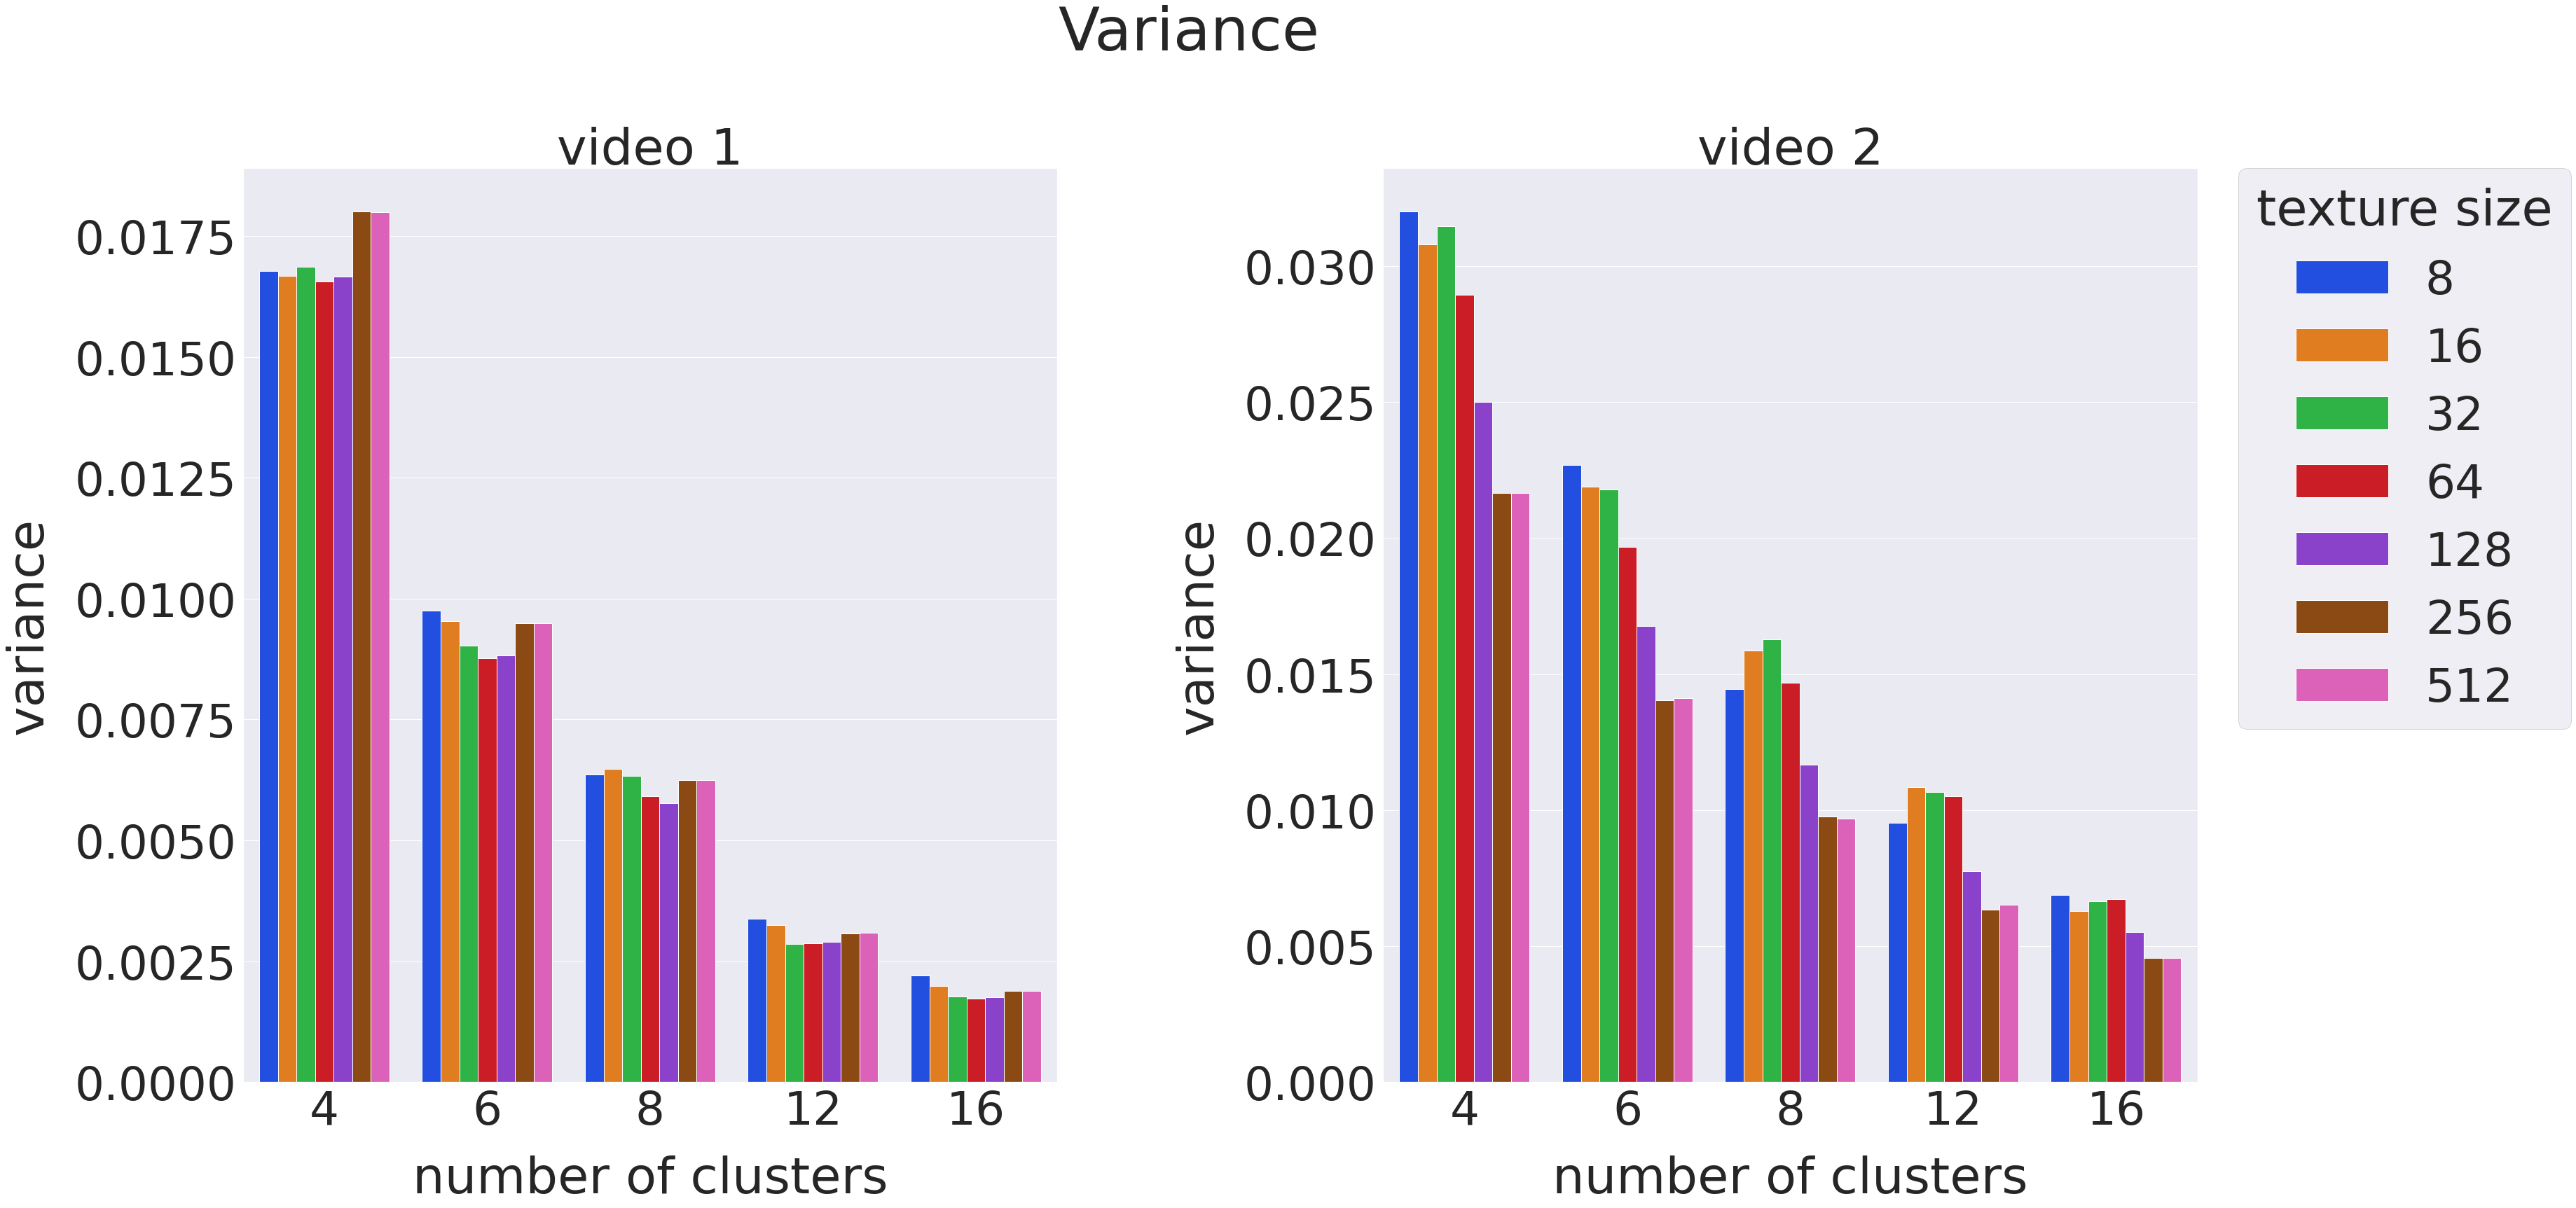

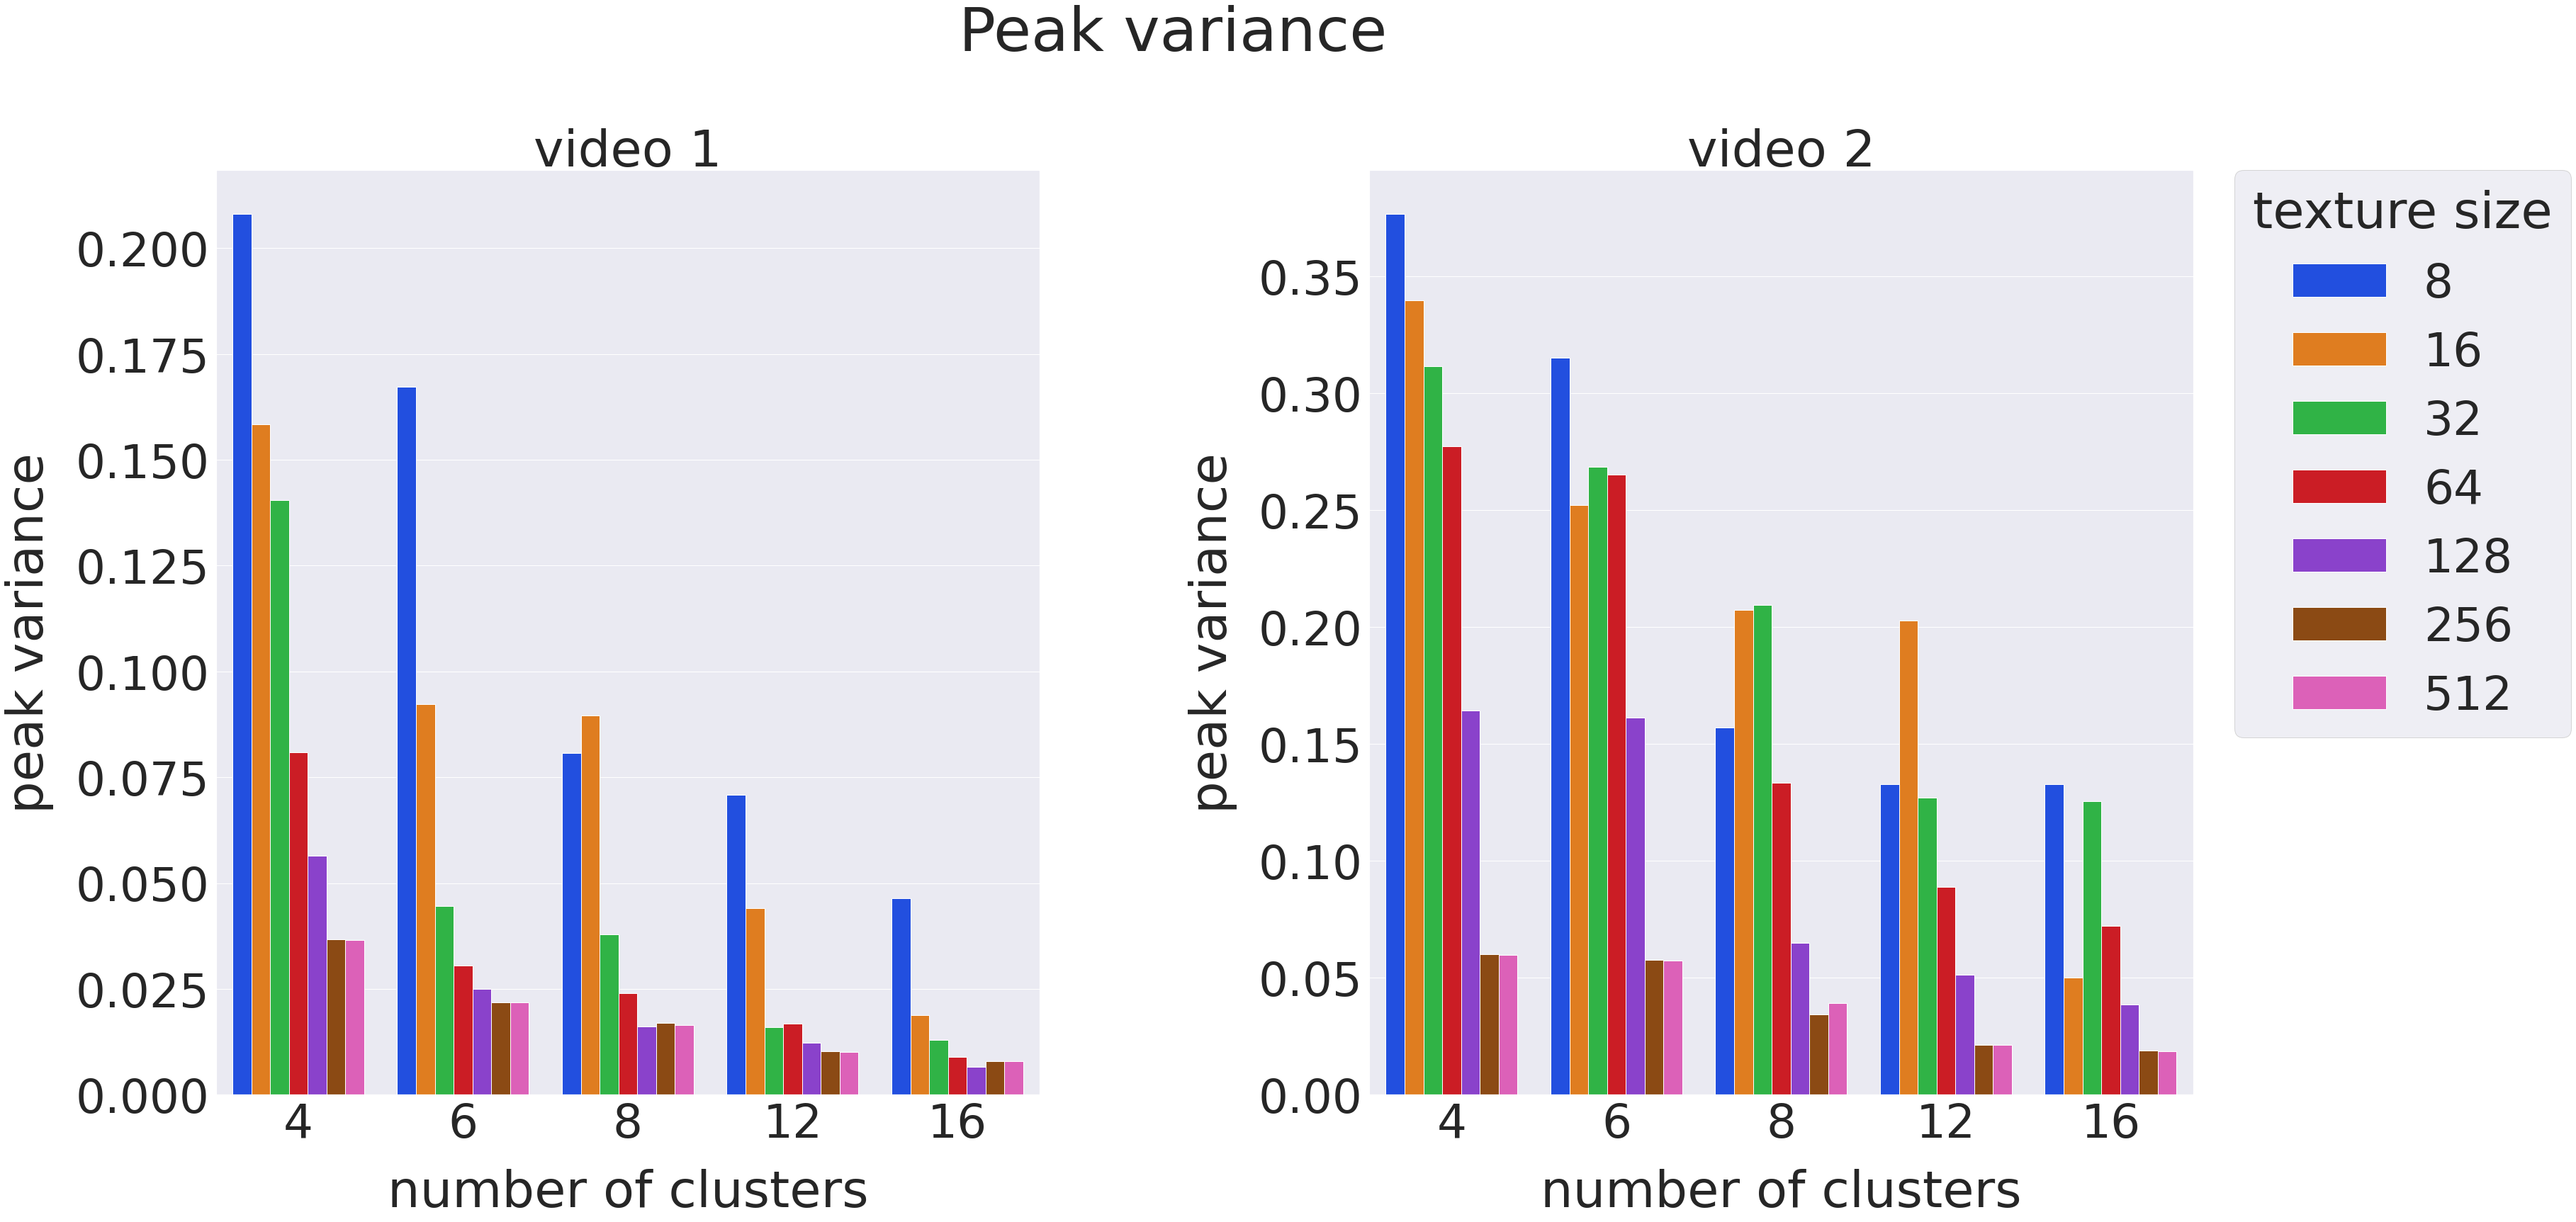

In [4]:
display(Markdown("## Plots"))

def subsample_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement["settings"]["texture size"]),
                    measurement["total variance"],
                    int(measurement["settings"]["number of clusters"]),
                )
                    for measurement in M1
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["texture size", "total variance", "number of clusters"]
        )



    total_variance_by_texture_size = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Variance")
    fig.subplots_adjust(top=.85)

    g = sb.barplot(
        x=total_variance_by_texture_size["video 1"]["number of clusters"],
        y=total_variance_by_texture_size["video 1"]["total variance"],
        ax=axes[0],
        hue=total_variance_by_texture_size["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("variance", labelpad=LABELPAD)
    axes[0].set_xlabel("number of clusters", labelpad=LABELPAD)
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=total_variance_by_texture_size["video 2"]["number of clusters"],
        y=total_variance_by_texture_size["video 2"]["total variance"],
        ax=axes[1],
        hue=total_variance_by_texture_size["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("variance", labelpad=LABELPAD)
    axes[1].set_xlabel("number of clusters", labelpad=LABELPAD)
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4
    )

    plt.show()
    
def subsample_peak_variance_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement["settings"]["texture size"]),
                    measurement["total variance"],
                    measurement["peak variance"],
                    int(measurement["settings"]["number of clusters"]),
                )
                    for measurement in M1
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "number of clusters"]
        )



    data = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    fig, axes = plt.subplots(1, 2)
    fig.suptitle("Peak variance")
    fig.subplots_adjust(top=.85)

    g = sb.barplot(
        x=data["video 1"]["number of clusters"],
        y=data["video 1"]["peak variance"],
        ax=axes[0],
        hue=data["video 1"]["texture size"],
        ci=None,
    )
    
    g.legend().remove()

    axes[0].set_ylabel("peak variance", labelpad=LABELPAD)
    axes[0].set_xlabel("number of clusters", labelpad=LABELPAD)
    axes[0].set_title("video 1")

    g = sb.barplot(
        x=data["video 2"]["number of clusters"],
        y=data["video 2"]["peak variance"],
        ax=axes[1],
        hue=data["video 2"]["texture size"],
        ci=None,
    )

    axes[1].set_ylabel("peak variance", labelpad=LABELPAD)
    axes[1].set_xlabel("number of clusters", labelpad=LABELPAD)
    axes[1].set_title("video 2")
    
    g.legend(
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        borderaxespad=0,
        title="texture size"
    )

    plt.subplots_adjust(
        wspace=0.4,
    )

    plt.show()
    
subsample_variance_plots()
subsample_peak_variance_plots()

In [5]:
display(Markdown("# Dataset 2: scaling vs subsampling"))

M2 = load_measurements("2. scaling vs subsampling")

M2 = sorted(
    M2,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["downscale"],
    )
)


show_measurements_table(M2)

# Dataset 2: scaling vs subsampling

video file  |  downscale  |  texture size  |  variance  |  peak variance
--------------------------------------------------------|----------------
1           |  No         |  256           |  0.00949   |0.02177   
1           |  Yes        |  256           |  0.00972   |0.02233   
1           |  No         |  128           |  0.00882   |0.02495   
1           |  Yes        |  128           |  0.00891   |0.03054   
1           |  No         |  64            |  0.00876   |0.03057   
1           |  Yes        |  64            |  0.00885   |0.04639   
1           |  No         |  32            |  0.00903   |0.04462   
1           |  Yes        |  32            |  0.00905   |0.04306   
1           |  No         |  16            |  0.00954   |0.09228   
1           |  Yes        |  16            |  0.00931   |0.09420   
1           |  No         |  8             |  0.00975   |0.16725   
1           |  Yes        |  8             |  0.01060   |0.18150   
2           |  No         |  256     

## Plots

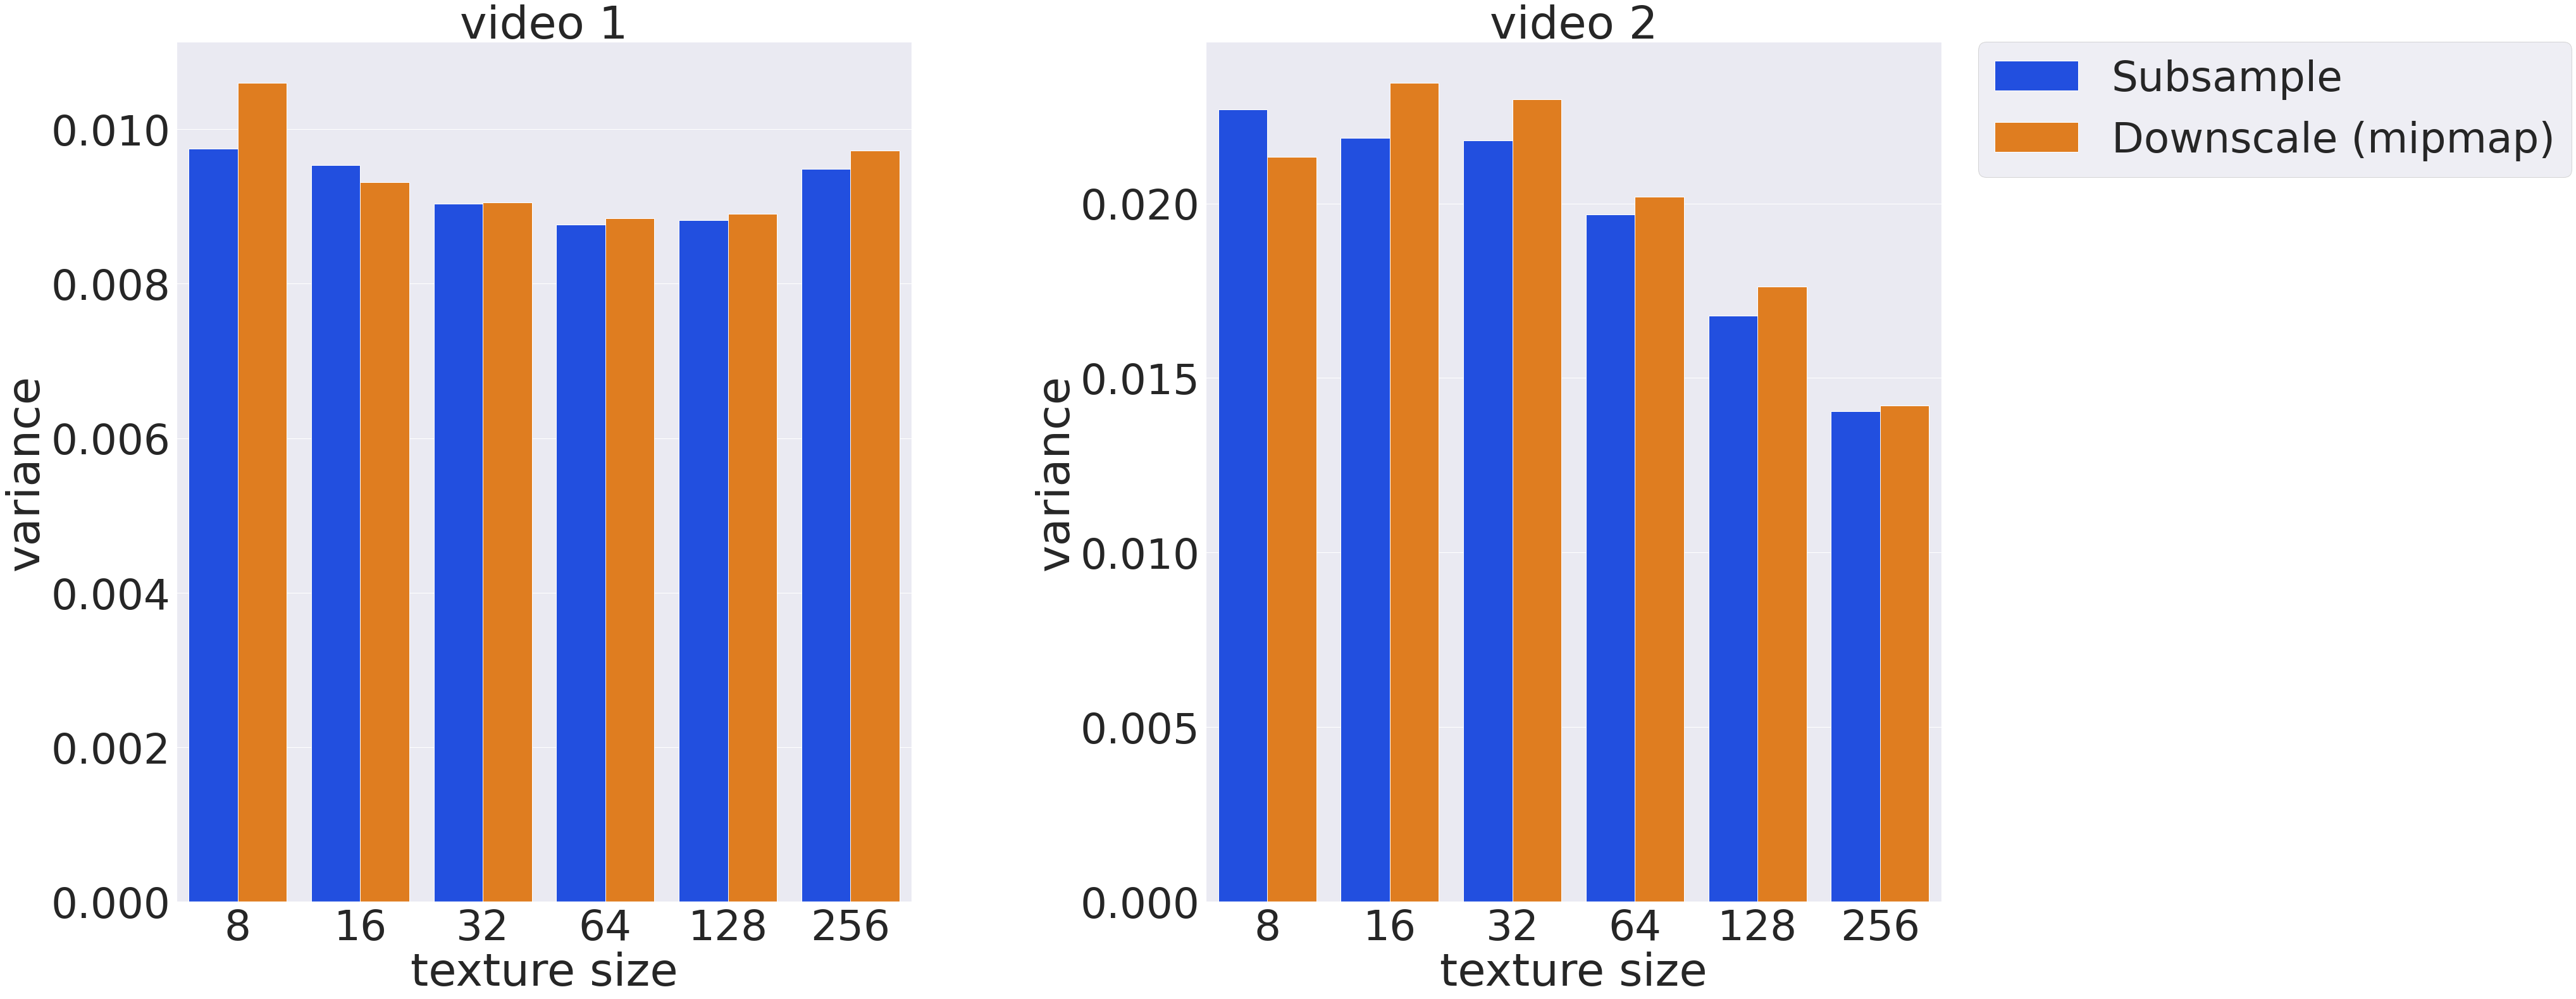

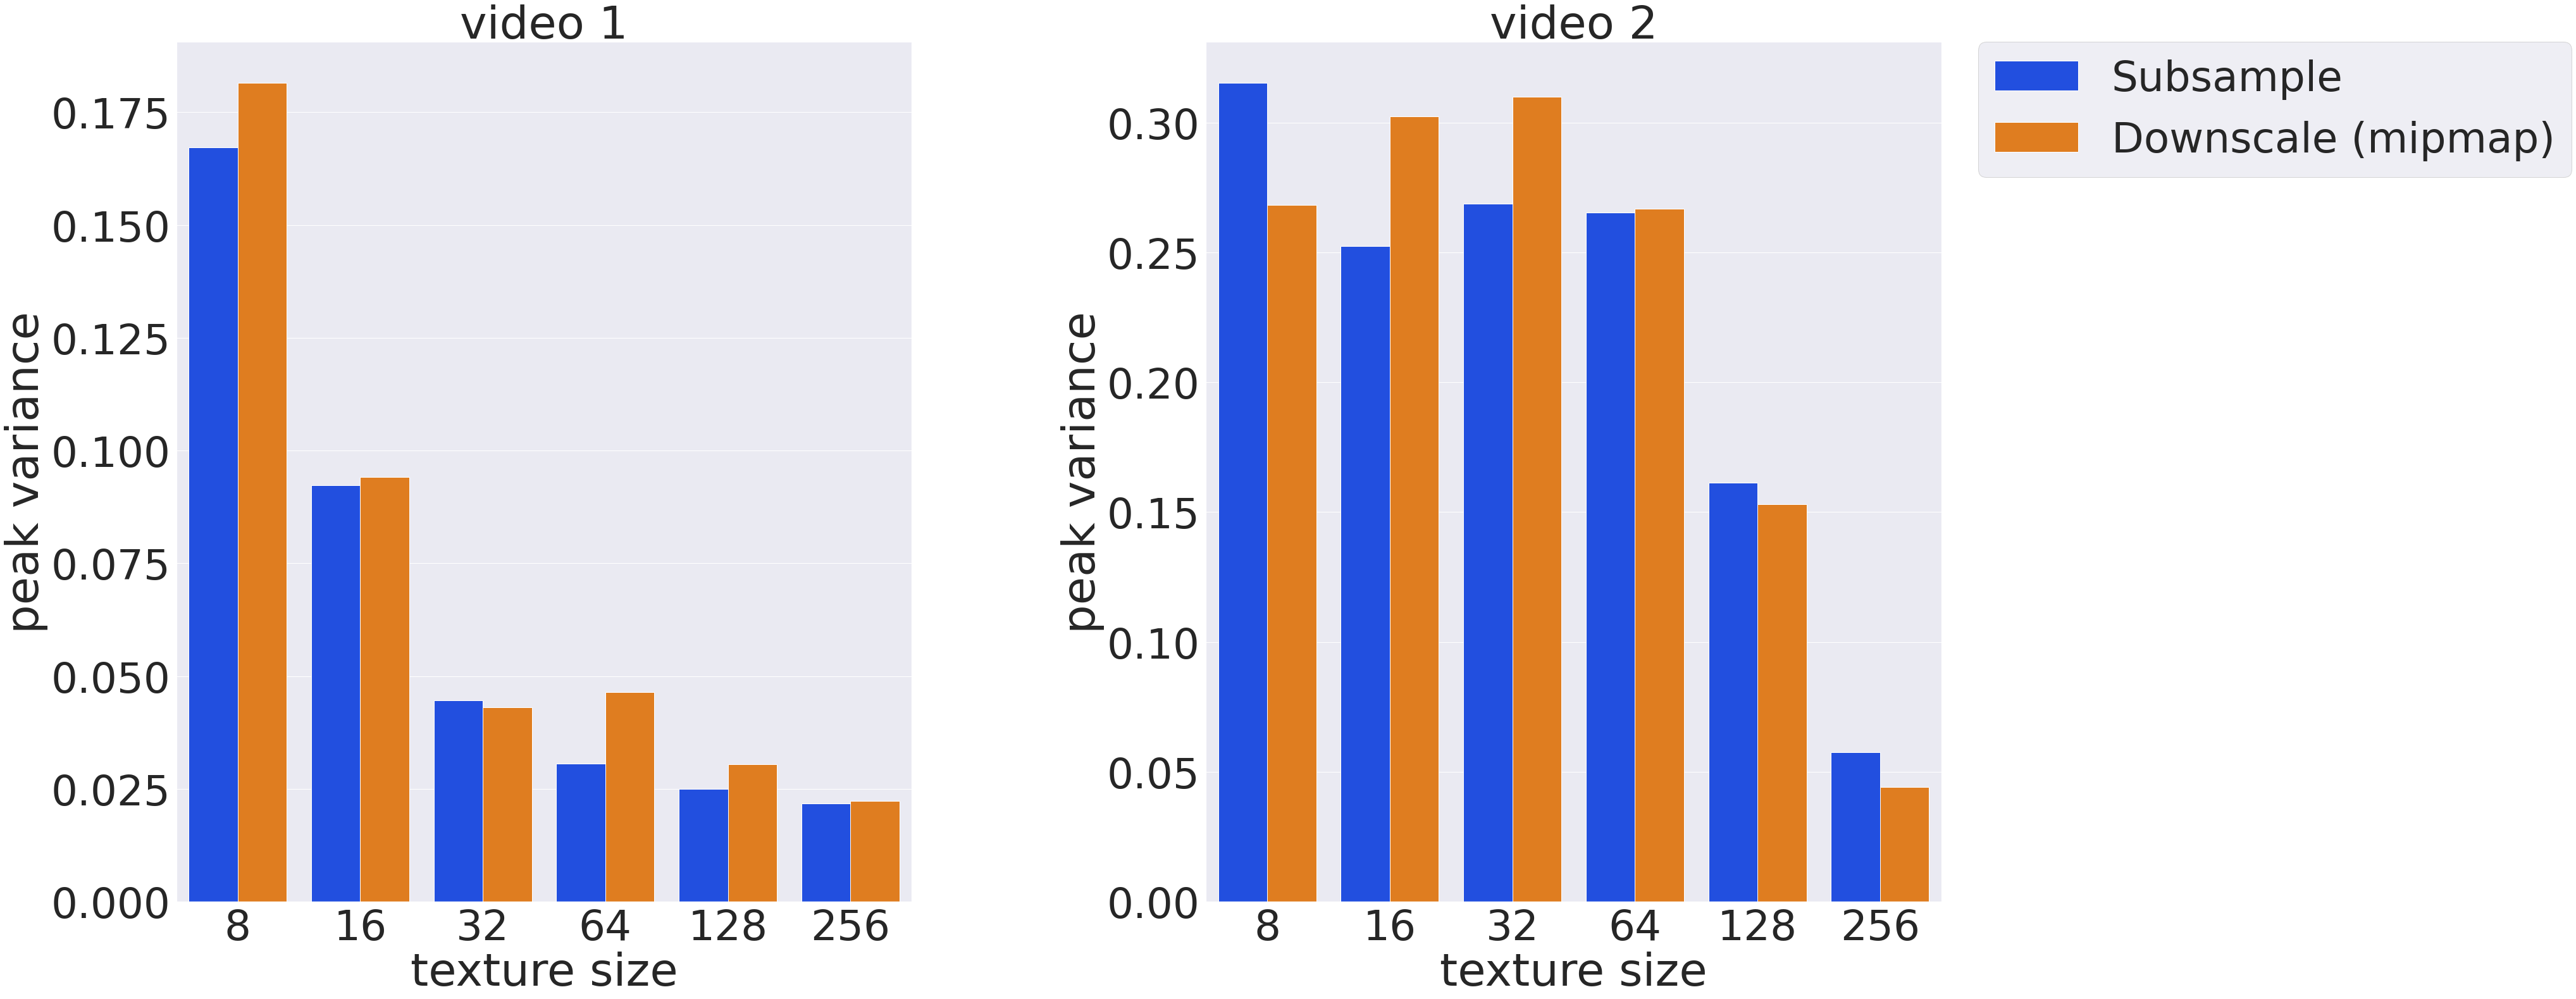

In [6]:
display(Markdown("## Plots"))

def subsample_vs_downscale_plots():
    
    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    measurement["total variance"],
                    measurement["peak variance"],
                    int(measurement["settings"]["texture size"]),
                    
                    "Downscale (mipmap)"
                            if measurement["settings"]["downscale"] == "Yes"
                    else "Subsample"     
                )
                    for measurement in M2
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["total variance", "peak variance", "texture size", "downscale"]
        )

    data_frames = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames["video 1"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames["video 2"],
            x="texture size",
            y="total variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
        )
        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames["video 1"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames["video 2"],
            x="texture size",
            y="peak variance",
            hue="downscale",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
        )
        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    plot_variance()
    plot_peak_variance()

subsample_vs_downscale_plots()

In [20]:
display(Markdown("# Jitter"))

# Jitter

In [8]:
display(Markdown("## Dataset 3: staggered jitter"))

M3 = load_measurements("3. staggered jitter")

M3 = sorted(
    M3,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)


show_measurements_table(M3)

## Dataset 3: staggered jitter

jitter size  |  video file  |  texture size  |  variance  |  peak variance
----------------------------------------------------------|----------------
1            |  1           |  512           |  0.00949   |0.02176   
1            |  1           |  256           |  0.00949   |0.02177   
2            |  1           |  256           |  0.00949   |0.02177   
1            |  1           |  128           |  0.00882   |0.02495   
2            |  1           |  128           |  0.00882   |0.02499   
4            |  1           |  128           |  0.00885   |0.02498   
1            |  1           |  64            |  0.00876   |0.03057   
2            |  1           |  64            |  0.00885   |0.03057   
4            |  1           |  64            |  0.00886   |0.04740   
8            |  1           |  64            |  0.00865   |0.03118   
1            |  1           |  32            |  0.00903   |0.04462   
16           |  1           |  32            |  0.00896   |0.08280   
2        

In [9]:
display(Markdown("## Dataset 4: scanline jitter"))

M4 = load_measurements("4. scanline jitter")

M4 = sorted(
    M4,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["jitter size"],
    )
)

show_measurements_table(M4)

## Dataset 4: scanline jitter

jitter size  |  video file  |  texture size  |  variance  |  peak variance
----------------------------------------------------------|----------------
1            |  1           |  512           |  0.00949   |0.02176   
1            |  1           |  256           |  0.00949   |0.02177   
2            |  1           |  256           |  0.00964   |0.02176   
1            |  1           |  128           |  0.00882   |0.02495   
2            |  1           |  128           |  0.00883   |0.02495   
4            |  1           |  128           |  0.00874   |0.02494   
1            |  1           |  64            |  0.00876   |0.03057   
2            |  1           |  64            |  0.00875   |0.03155   
4            |  1           |  64            |  0.00876   |0.04956   
8            |  1           |  64            |  0.00870   |0.03142   
1            |  1           |  32            |  0.00903   |0.04462   
16           |  1           |  32            |  0.00880   |0.04871   
2        

## Plots

### Staggered jitter

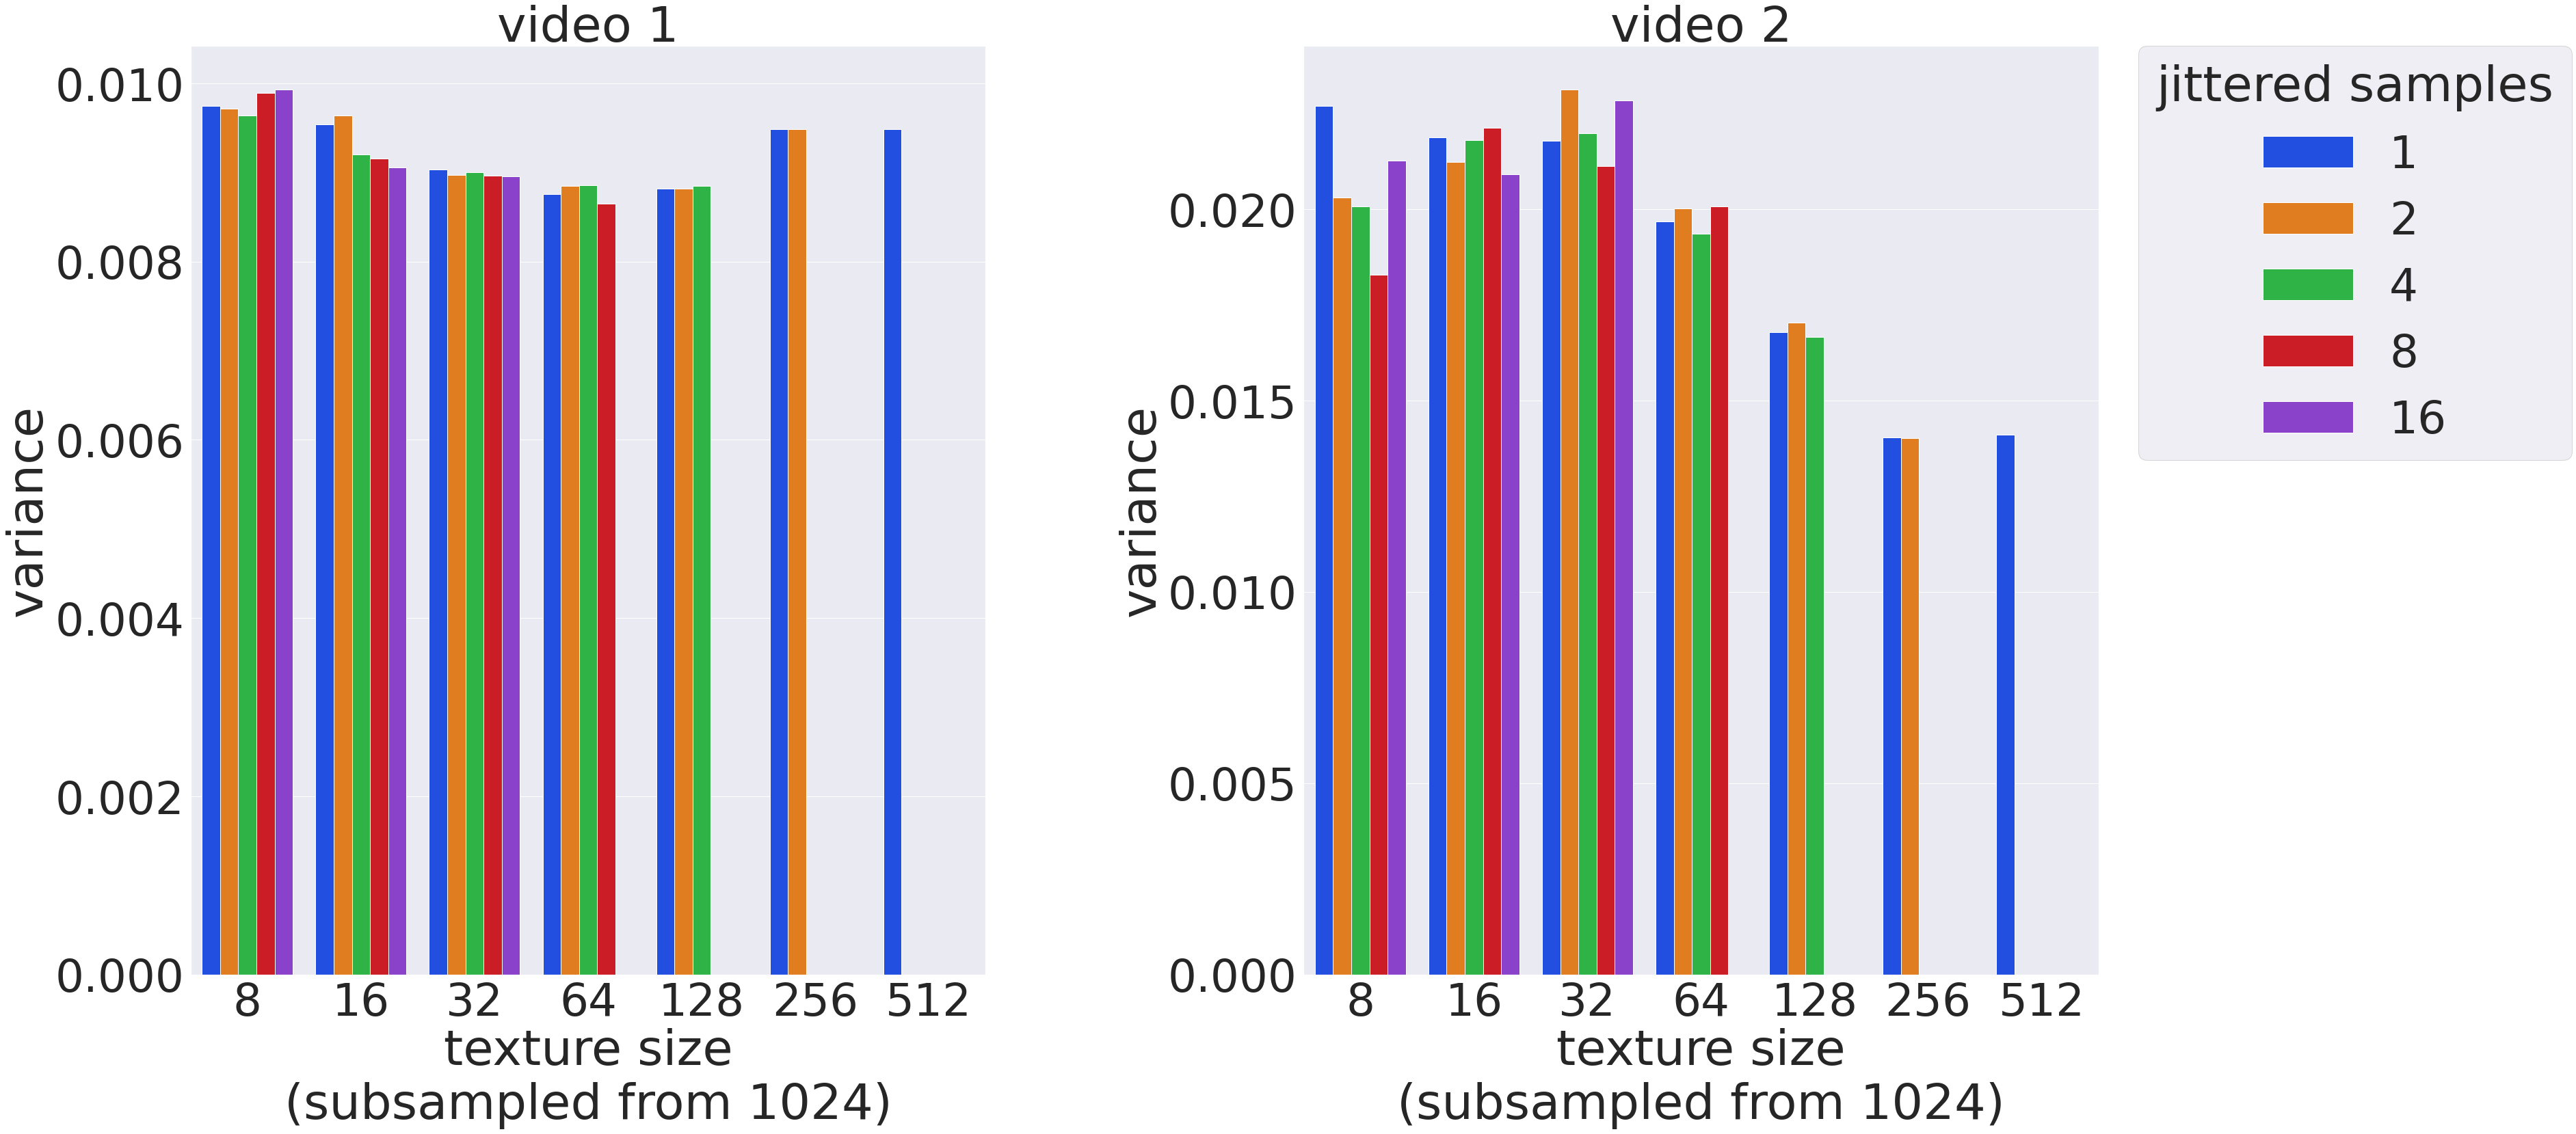

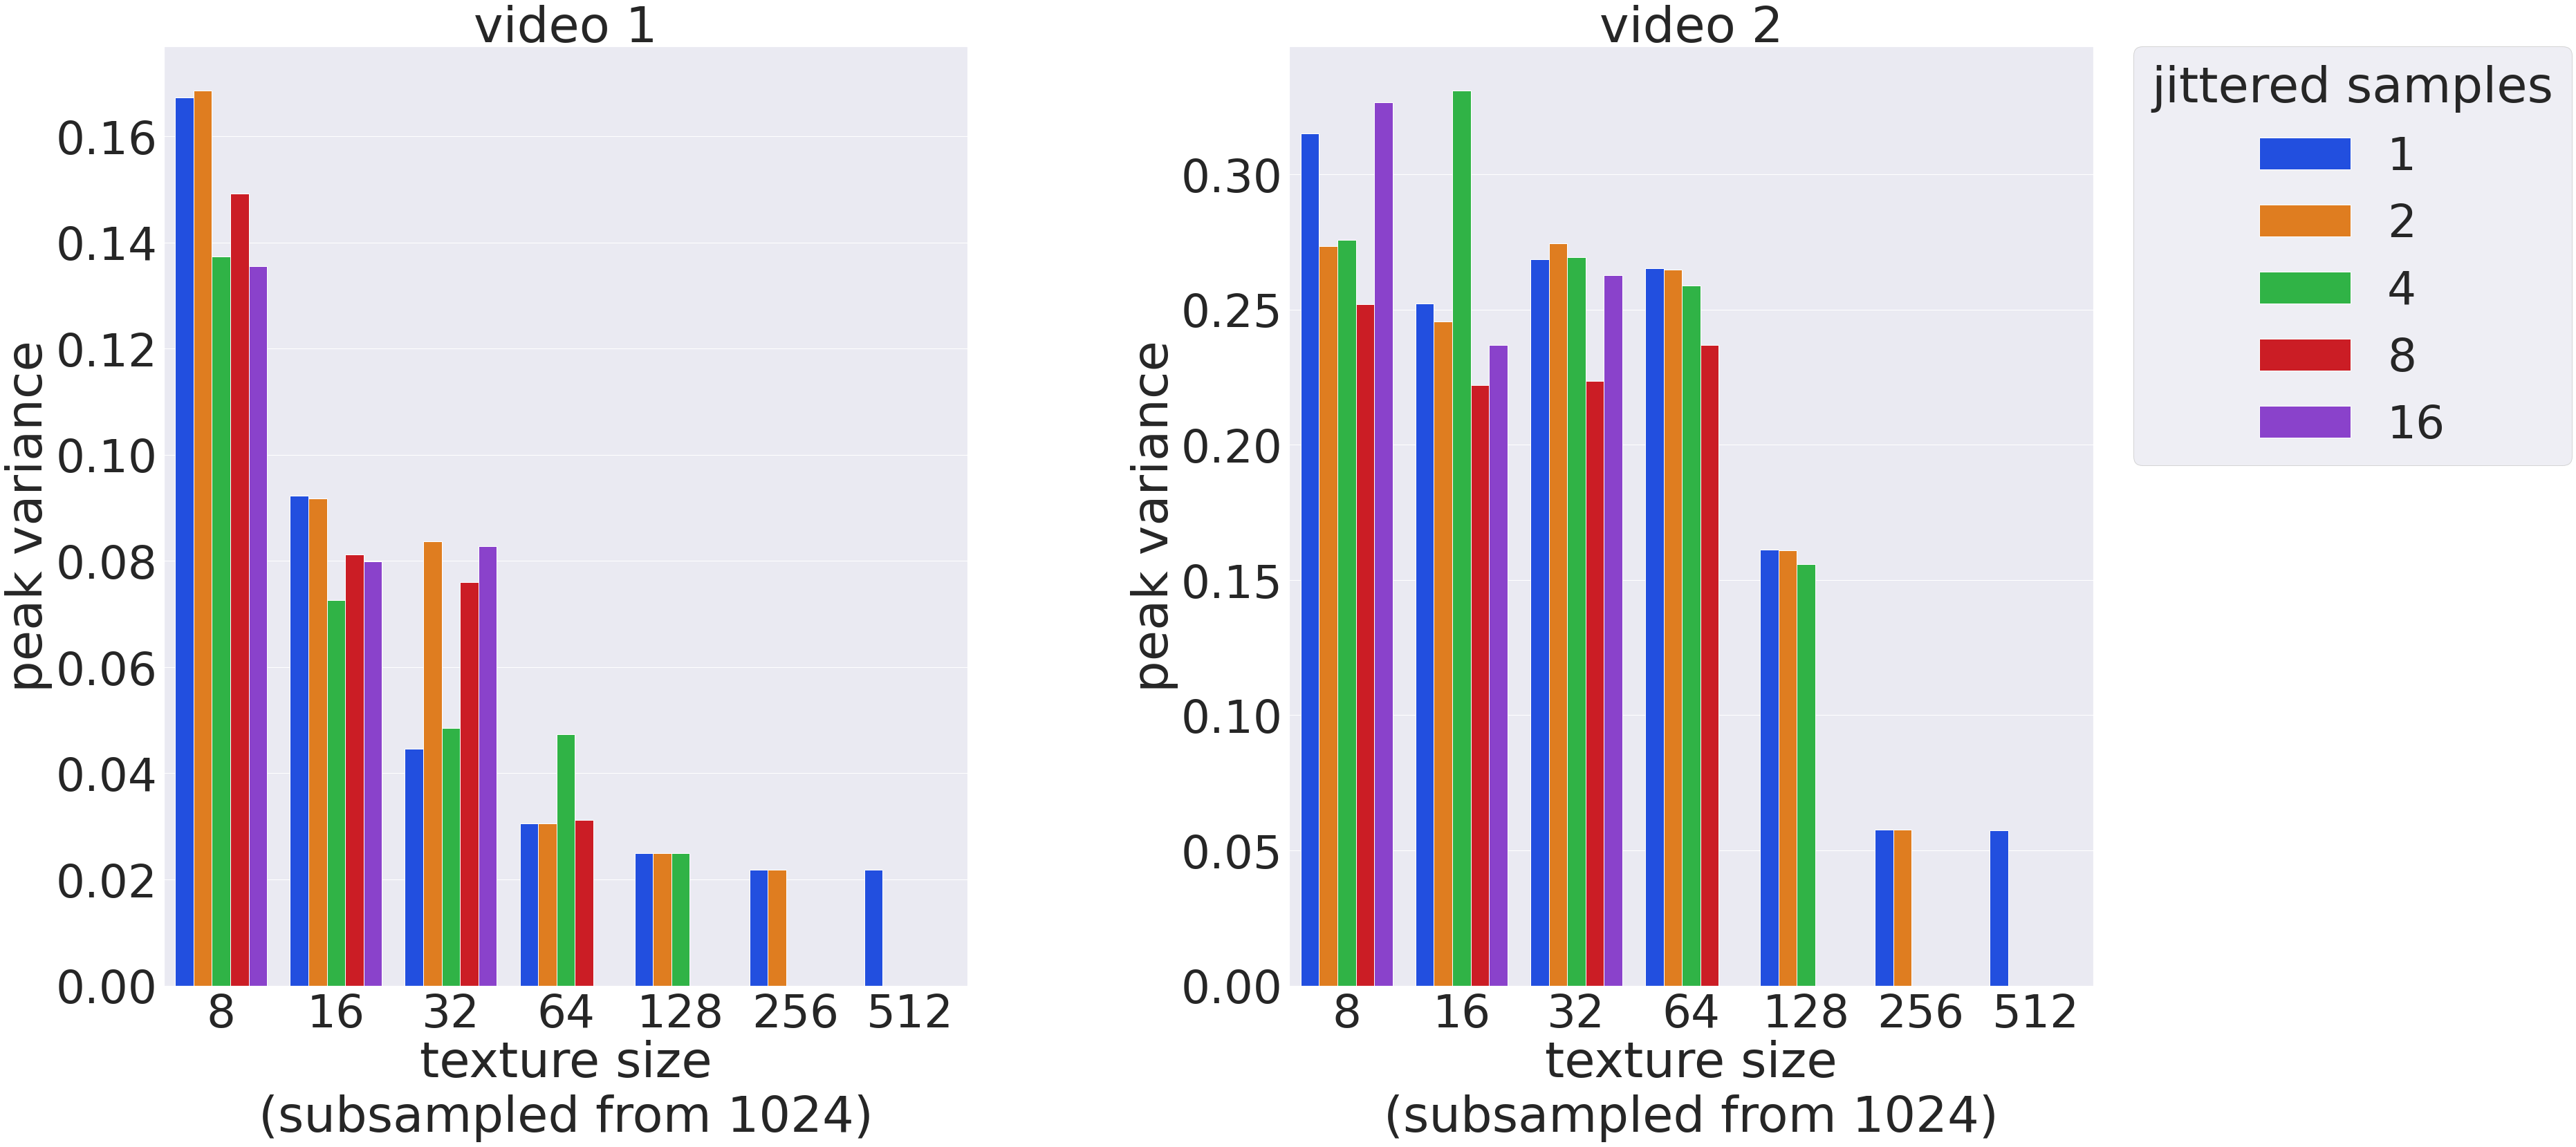

### Scanline jitter

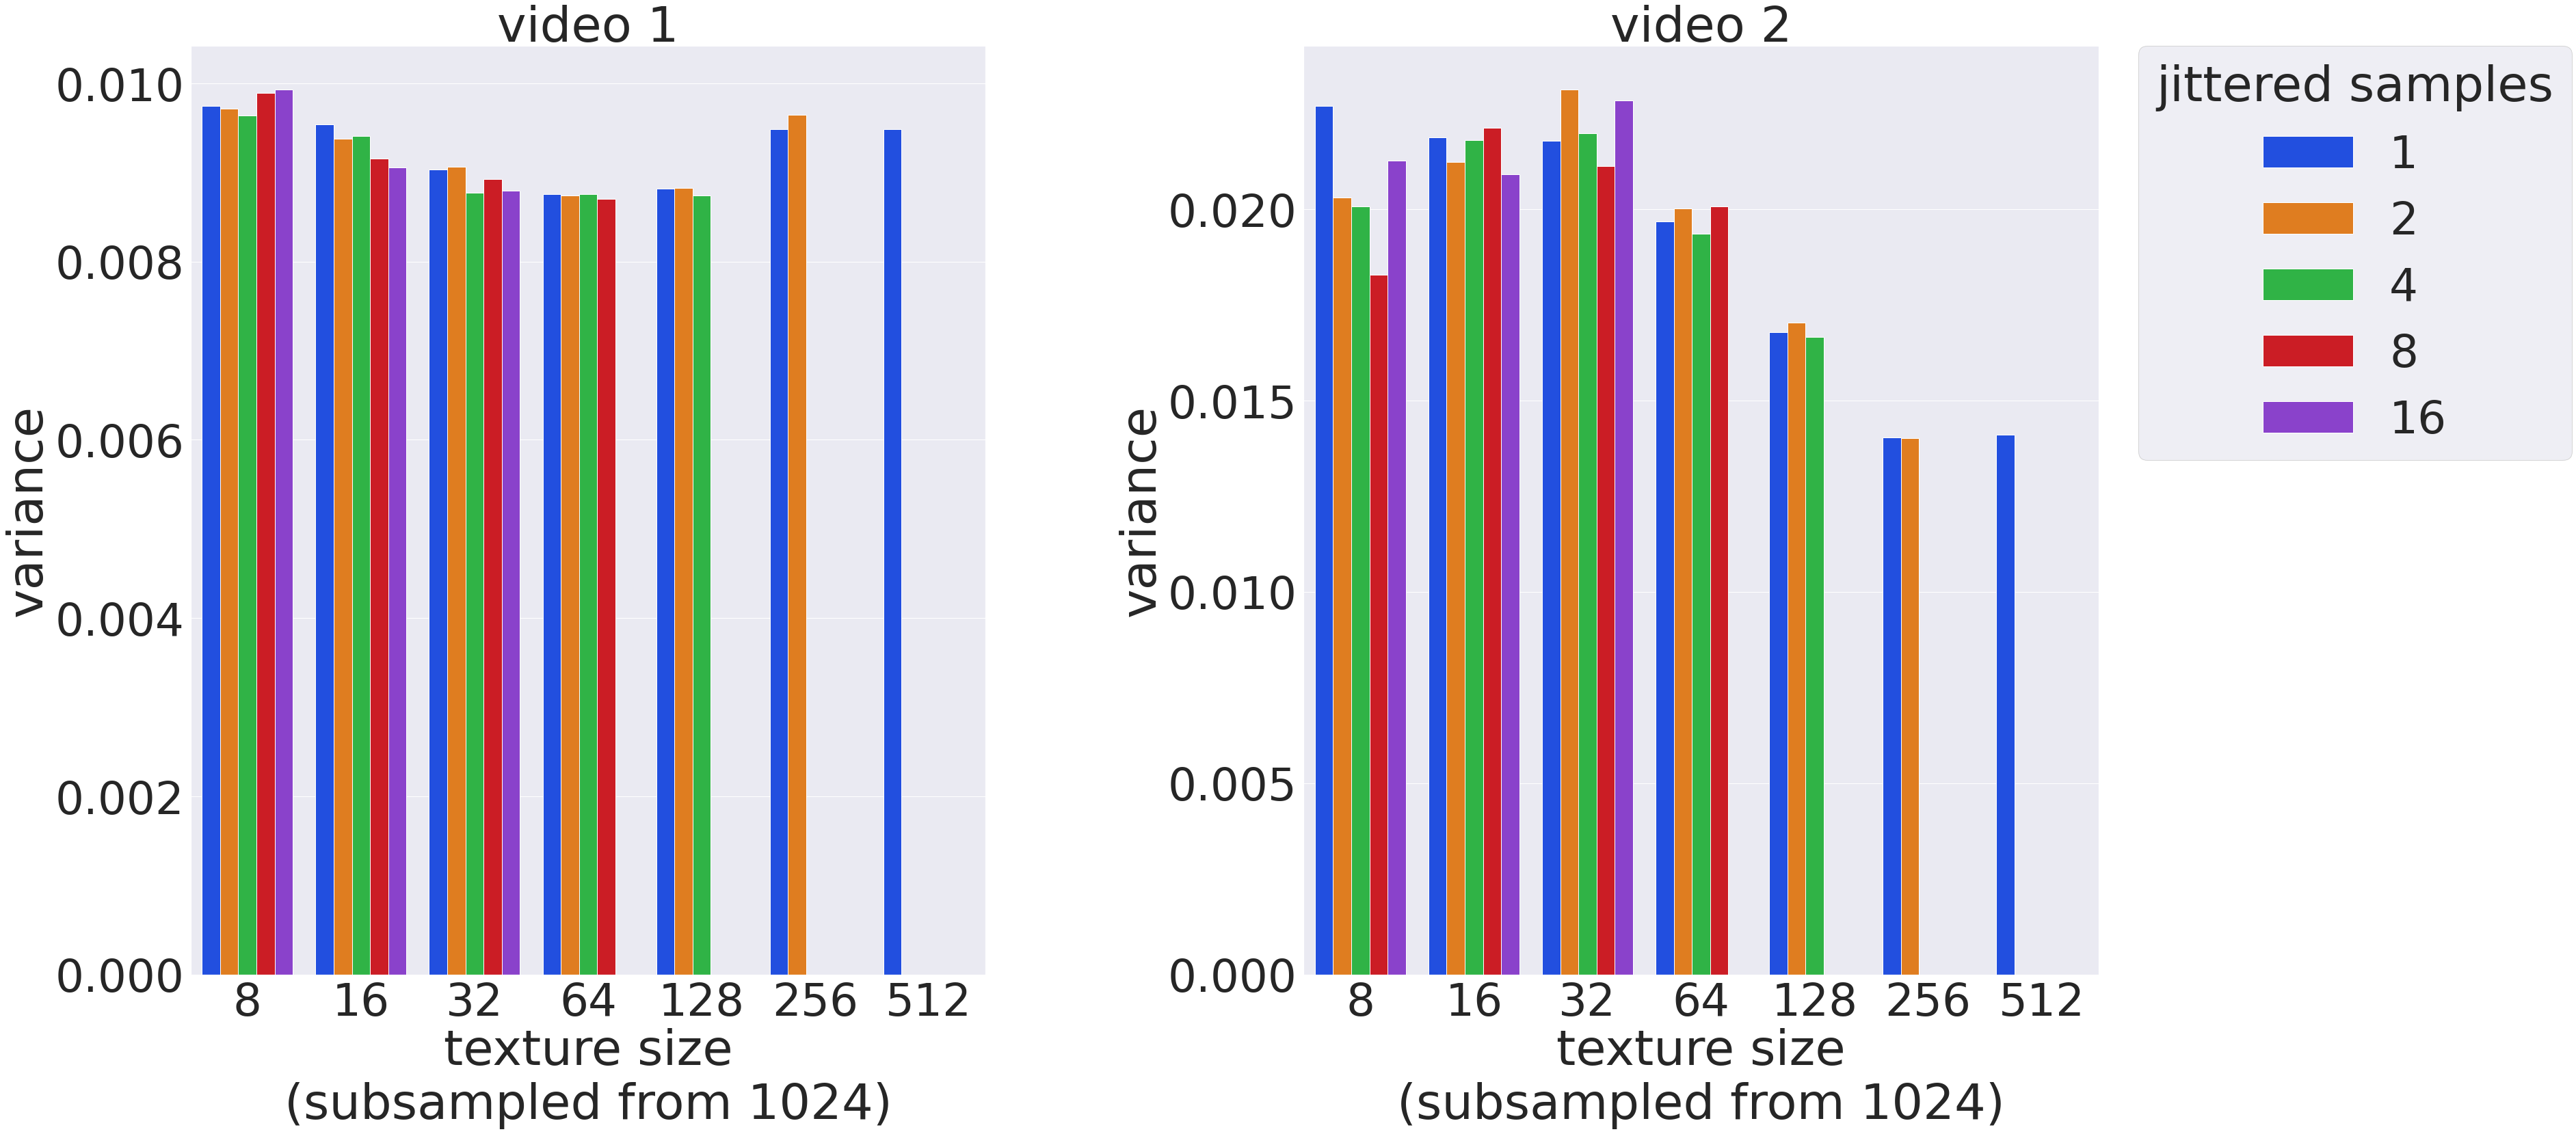

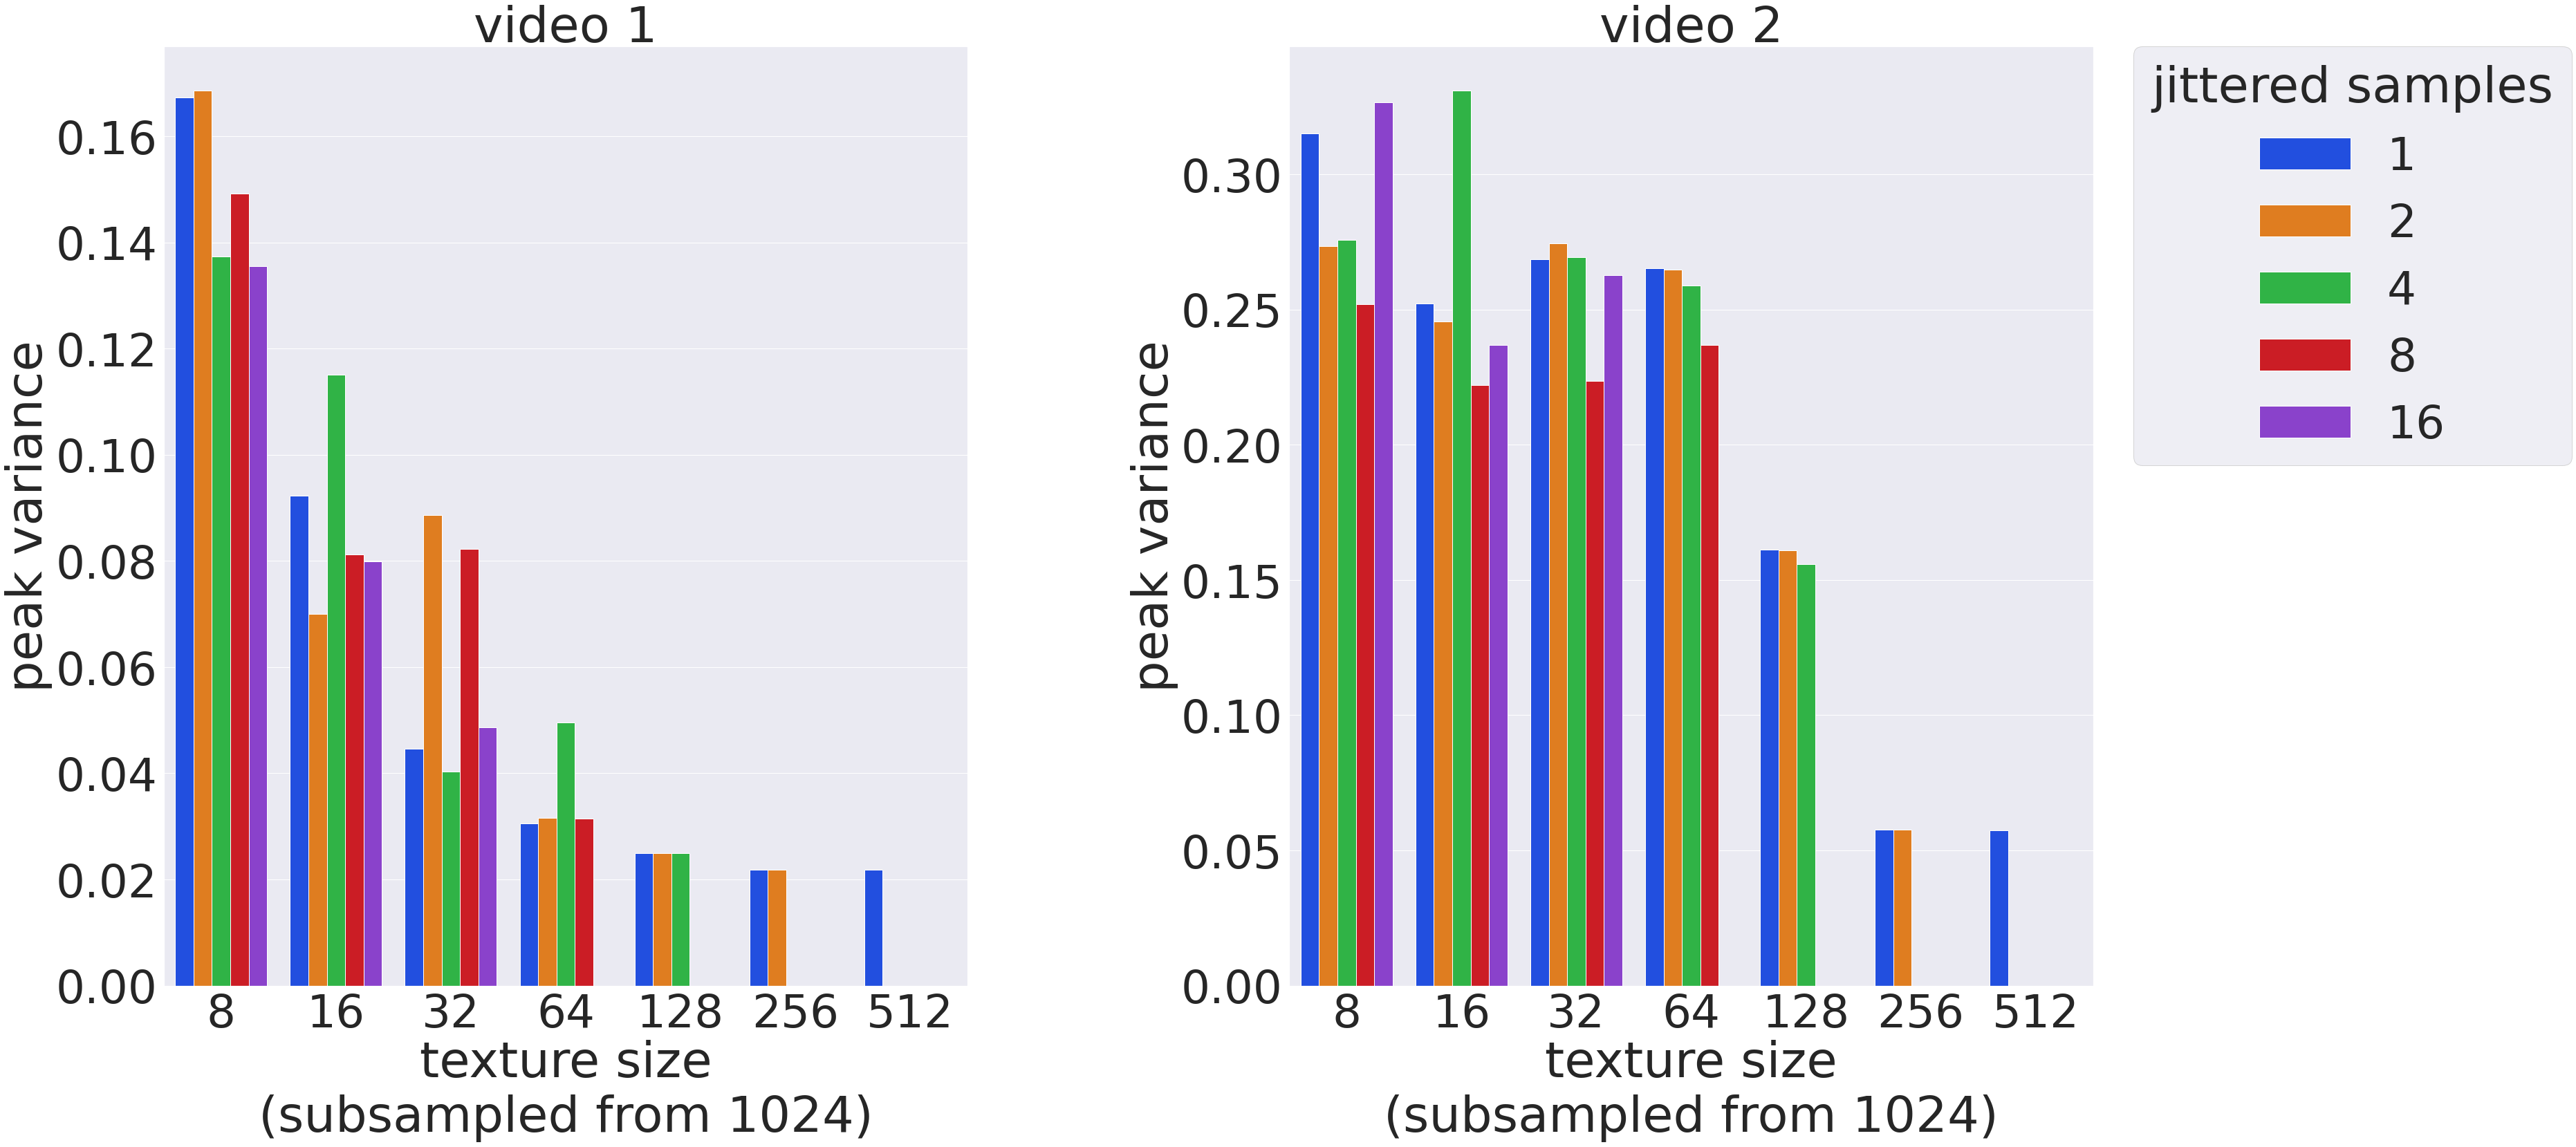

### Difference

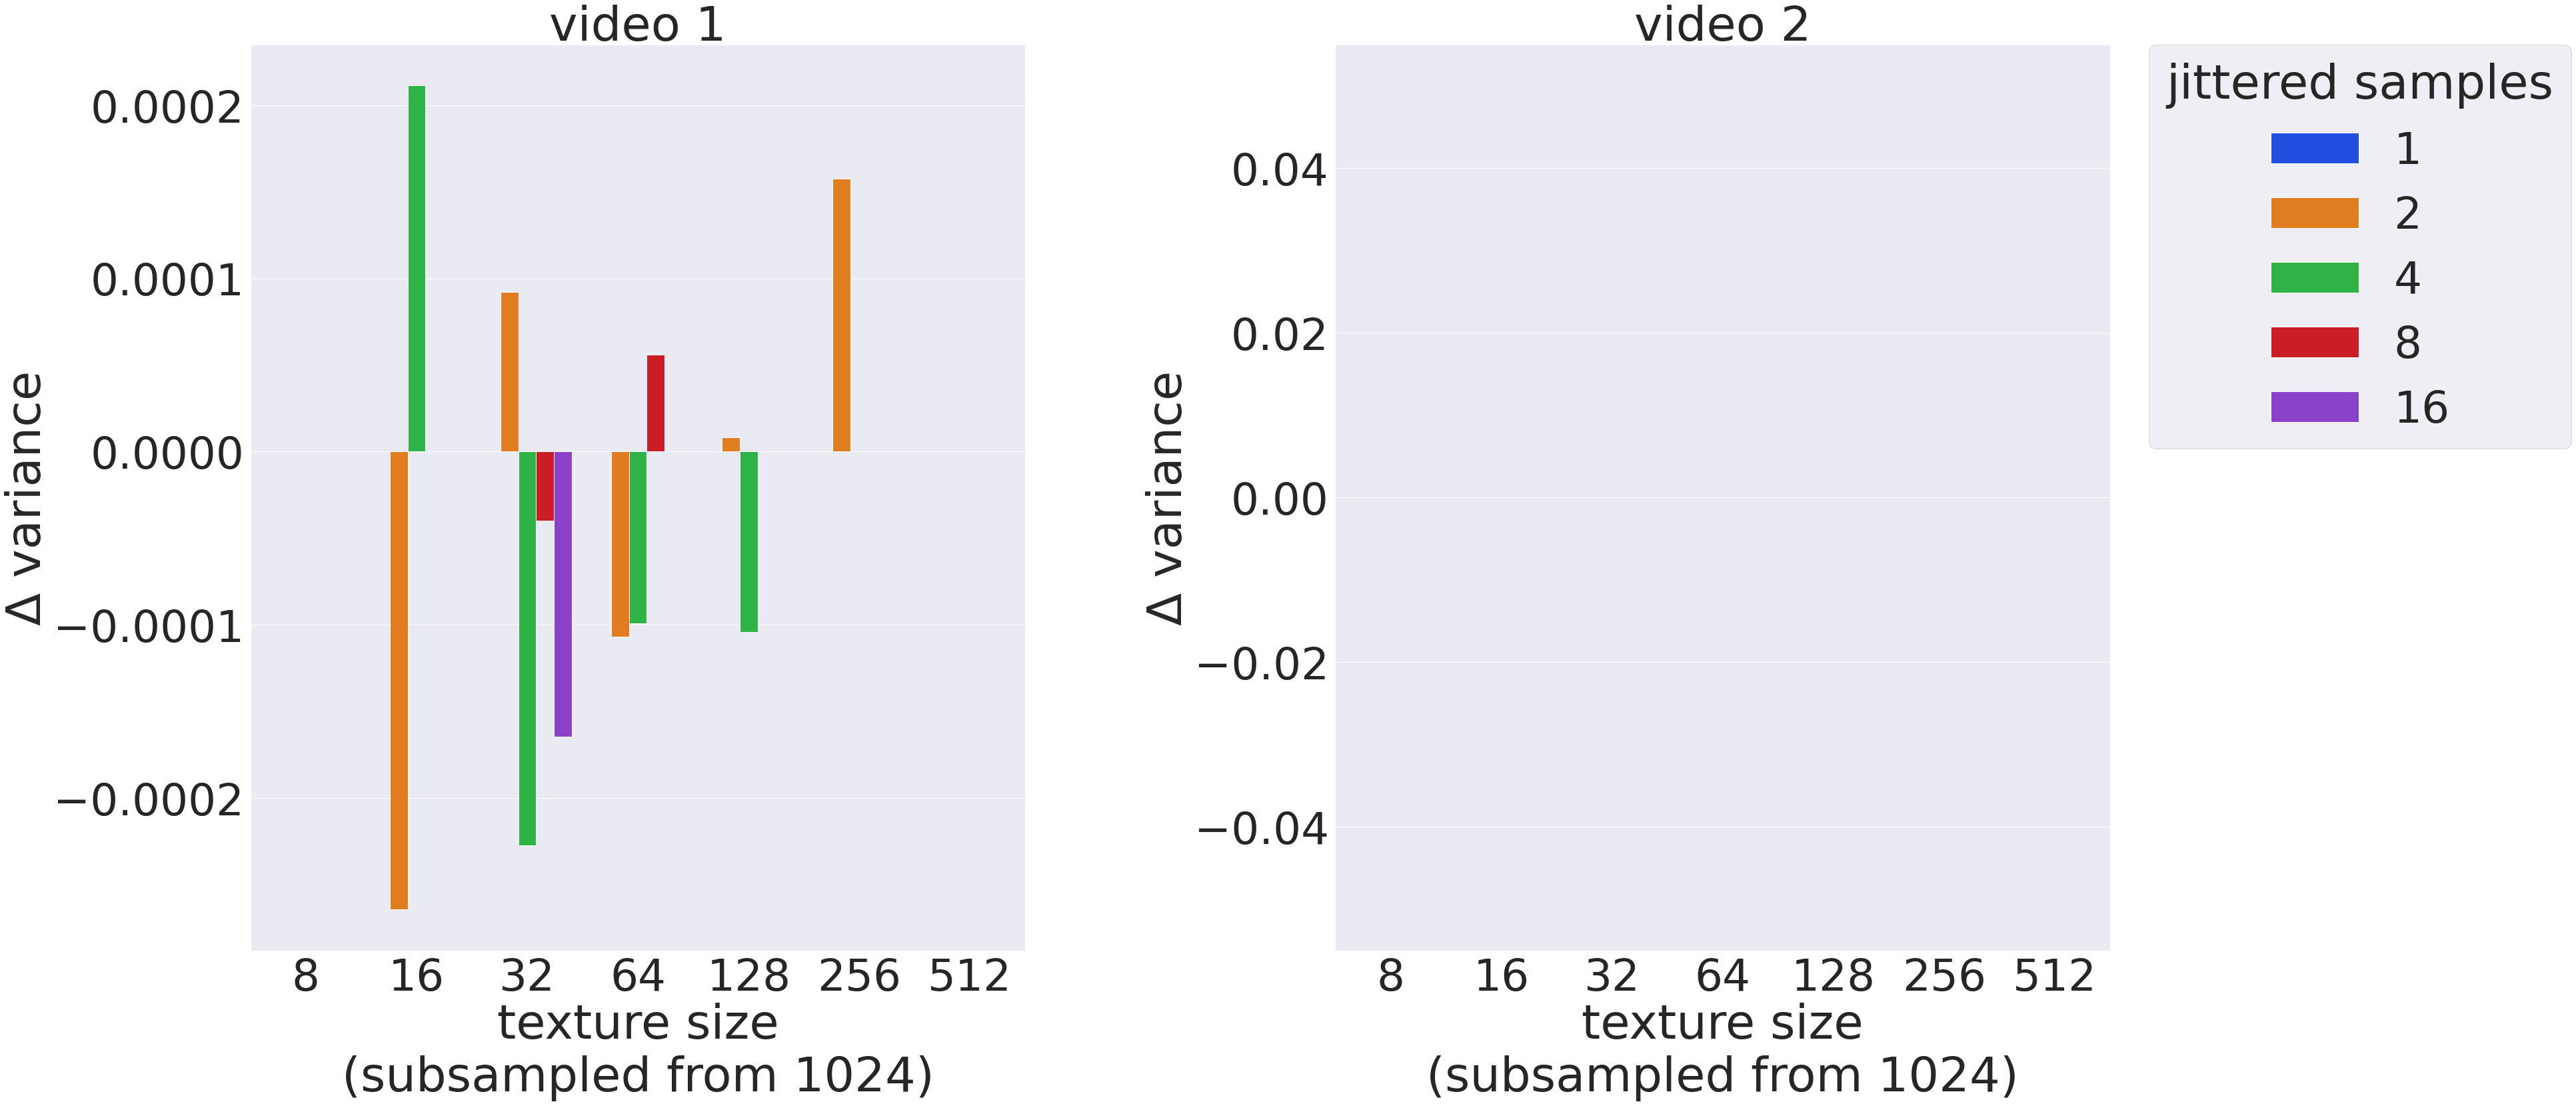

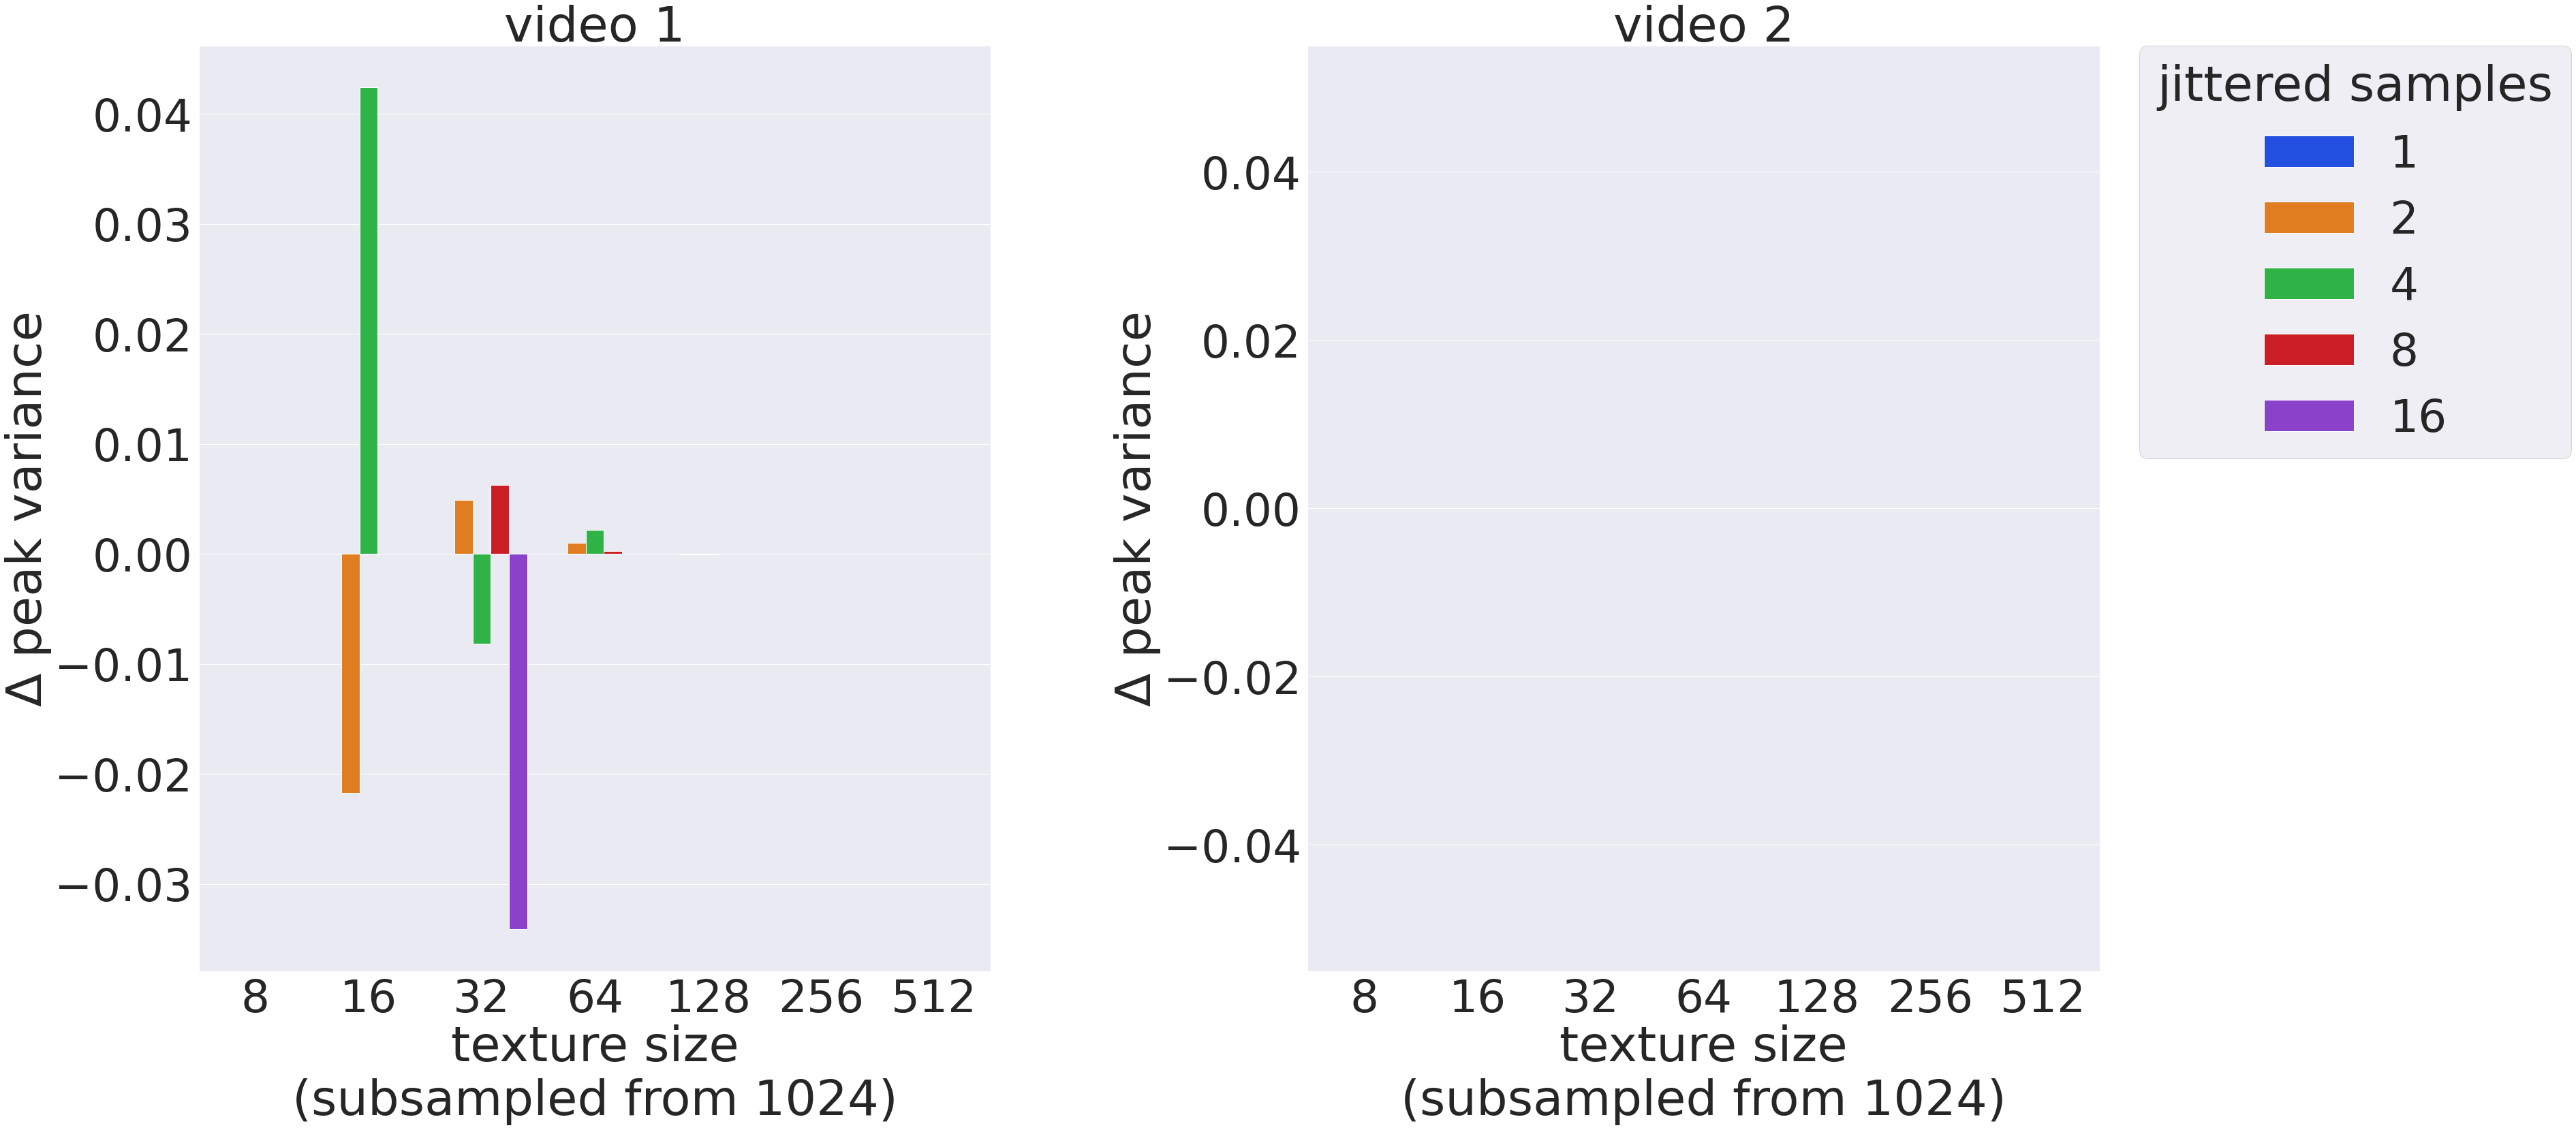


Positive numbers mean variance is greater with scanline jitter.
            

In [22]:
display(Markdown("## Plots"))

def jitter_plots():
    
    def load_video(video_name, measurements):
        return pd.DataFrame(
            [
                (
                    int(measurement["settings"]["texture size"]),
                    measurement["total variance"],
                    measurement["peak variance"],
                    int(measurement["settings"]["jitter size"])
                )
                    for measurement in measurements
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "jitter size"]
        )
    
    def load_video_delta(video_name):
        return pd.DataFrame(
            [
                (
                    int(M4[i]["settings"]["texture size"]),
                    M4[i]["total variance"] - M3[i]["total variance"],
                    M4[i]["peak variance"] - M3[i]["peak variance"],
                    int(M4[i]["settings"]["jitter size"])
                )
                    for i in range(len(M4))
                        if M4[i]["settings"]["video file"] == video_name
            ],
            columns=["texture size", "delta variance", "delta peak variance", "jitter size"]
        )


    data_frames_staggered_jitter = {
        f"video {video}" : load_video(video, M3)
            for video in ["1", "2"]
    }
    
    data_frames_scanline_jitter = {
        f"video {video}" : load_video(video, M4)
            for video in ["1", "2"]
    }
    
    data_frames_delta = {
        f"video {video}" : load_video_delta(video)
            for video in ["1", "2"]
    }

    display(Markdown("### Staggered jitter"))
    
    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_staggered_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()    
    
    display(Markdown("### Scanline jitter"))

    def plot_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 1"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 2"],
            x="texture size",
            y="total variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 1"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_scanline_jitter["video 2"],
            x="texture size",
            y="peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_variance()
    plot_peak_variance()
    
    display(Markdown("### Difference"))
    
    def plot_delta_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_delta["video 1"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_delta["video 2"],
            x="texture size",
            y="delta variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def plot_delta_peak_variance():
    
        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            data=data_frames_delta["video 1"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[0],
        )

        g.legend().remove()

        axes[0].set_ylabel("Δ peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            data=data_frames_delta["video 2"],
            x="texture size",
            y="delta peak variance",
            hue="jitter size",
            ci=None,
            ax = axes[1],
        )

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="jittered samples"
        )

        axes[1].set_ylabel("Δ peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
        
    plot_delta_variance()
    plot_delta_peak_variance()
    
    display(
        Markdown(
            """
Positive numbers mean variance is greater with scanline jitter.
            """
        )
    )

jitter_plots()

display(
    Markdown(
        """

        """
    )
)

In [11]:
display(Markdown("# Dataset 5: empty cluster randomization"))

M5 = load_measurements("5. empty cluster randomization")

M5 = sorted(
    M5,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        -int(measurement["settings"]["texture size"]),
        measurement["settings"]["randomize empty clusters"],
    )
)

show_measurements_table(M5)

# Dataset 5: empty cluster randomization

video file  |  randomize empty clusters  |  texture size  |  variance  |  peak variance
-----------------------------------------------------------------------|----------------
1           |  No                        |  512           |  0.00765   |0.01518   
1           |  Yes                       |  512           |  0.00765   |0.01518   
1           |  No                        |  256           |  0.00766   |0.01719   
1           |  Yes                       |  256           |  0.00766   |0.01719   
1           |  No                        |  128           |  0.00765   |0.01518   
1           |  Yes                       |  128           |  0.00765   |0.01518   
1           |  No                        |  64            |  0.00764   |0.01509   
1           |  Yes                       |  64            |  0.00767   |0.01509   
1           |  No                        |  32            |  0.00772   |0.01549   
1           |  Yes                       |  32            |  0.00773   |0.01

## Plots

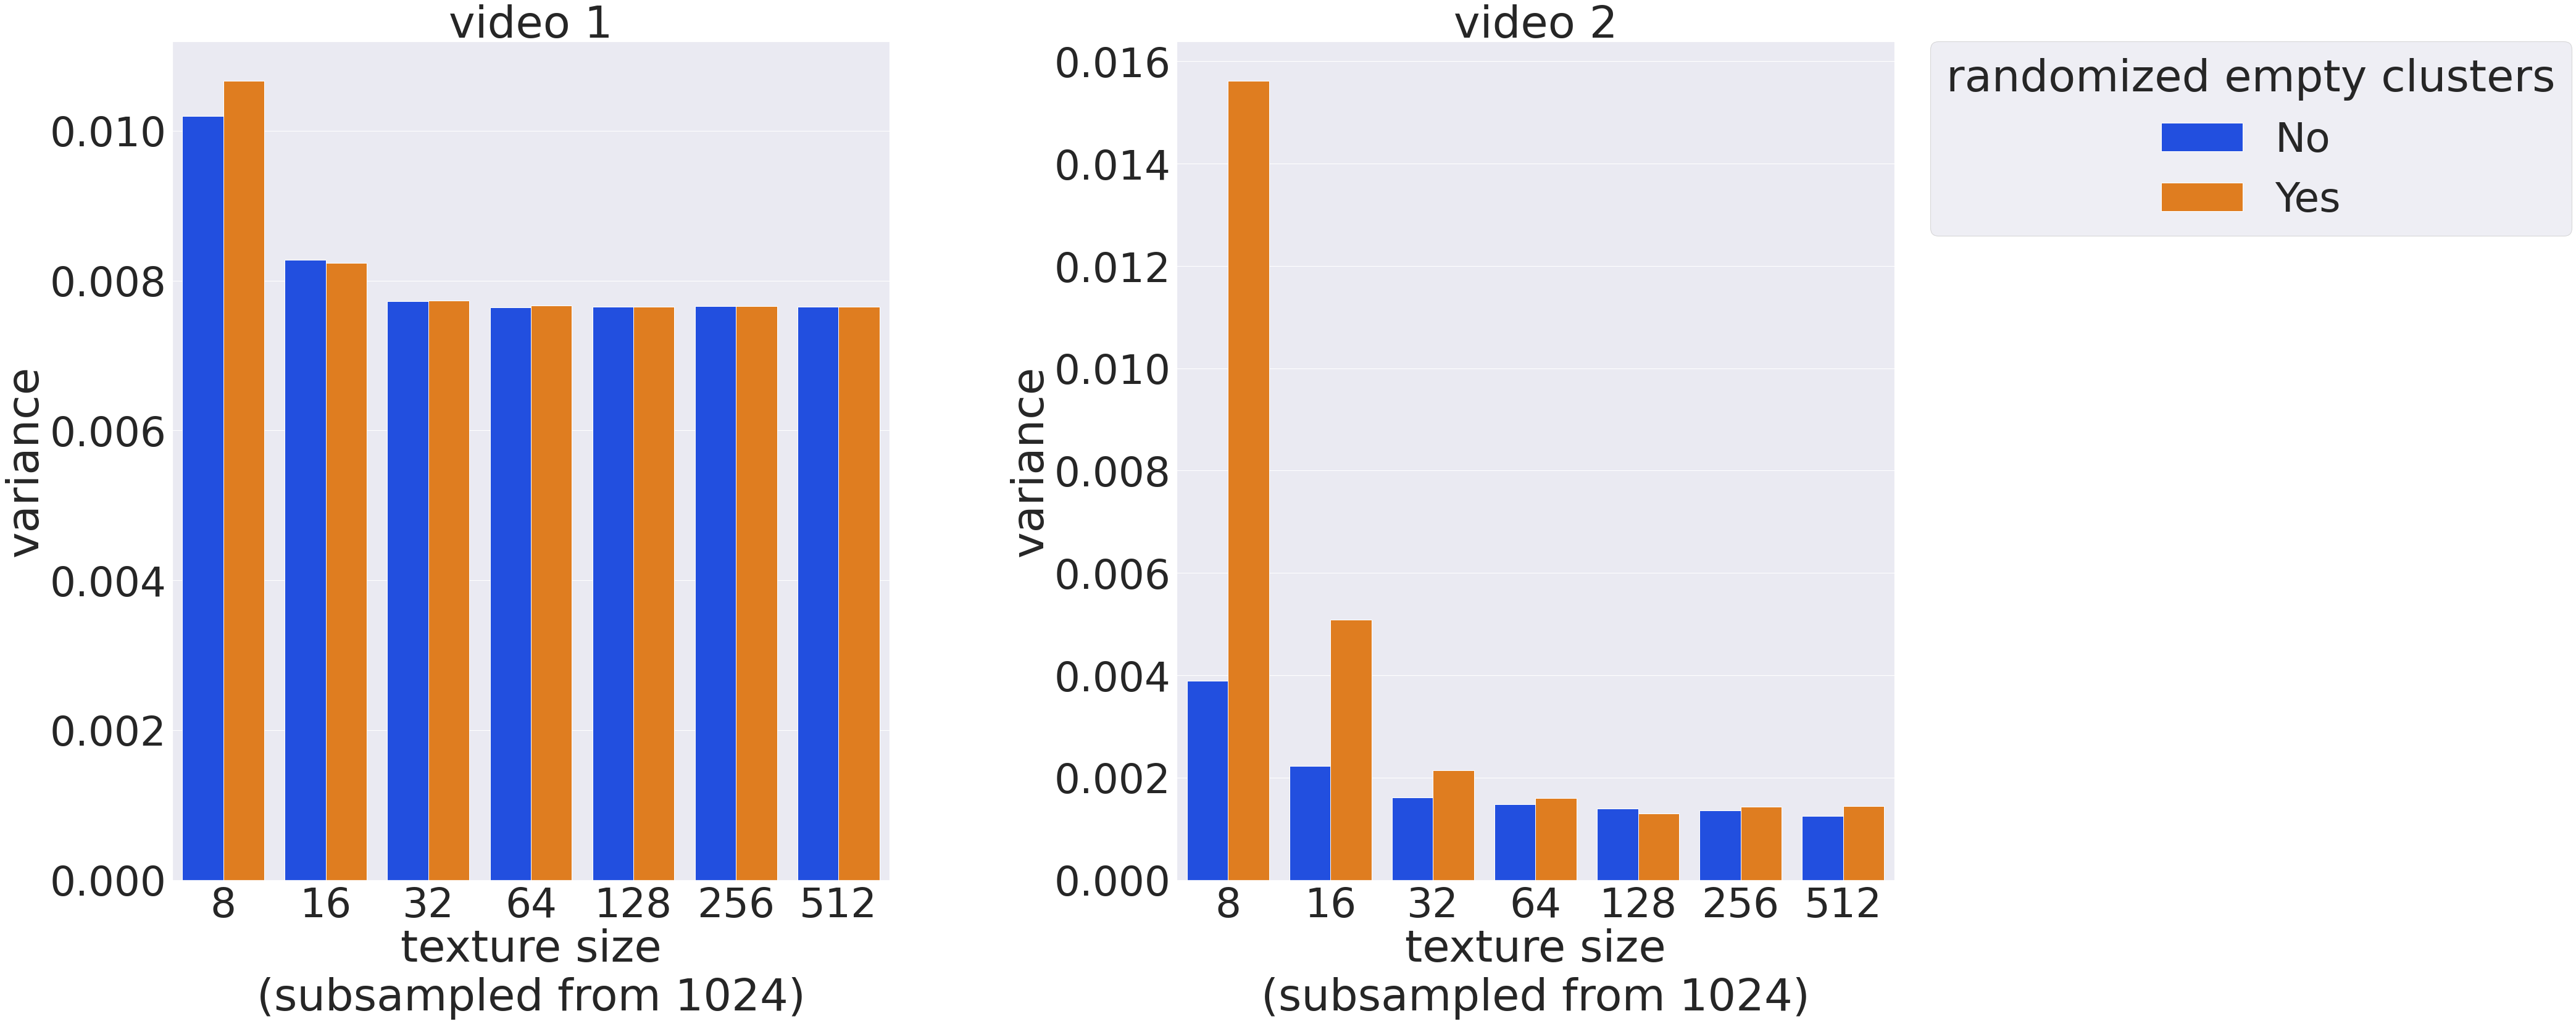

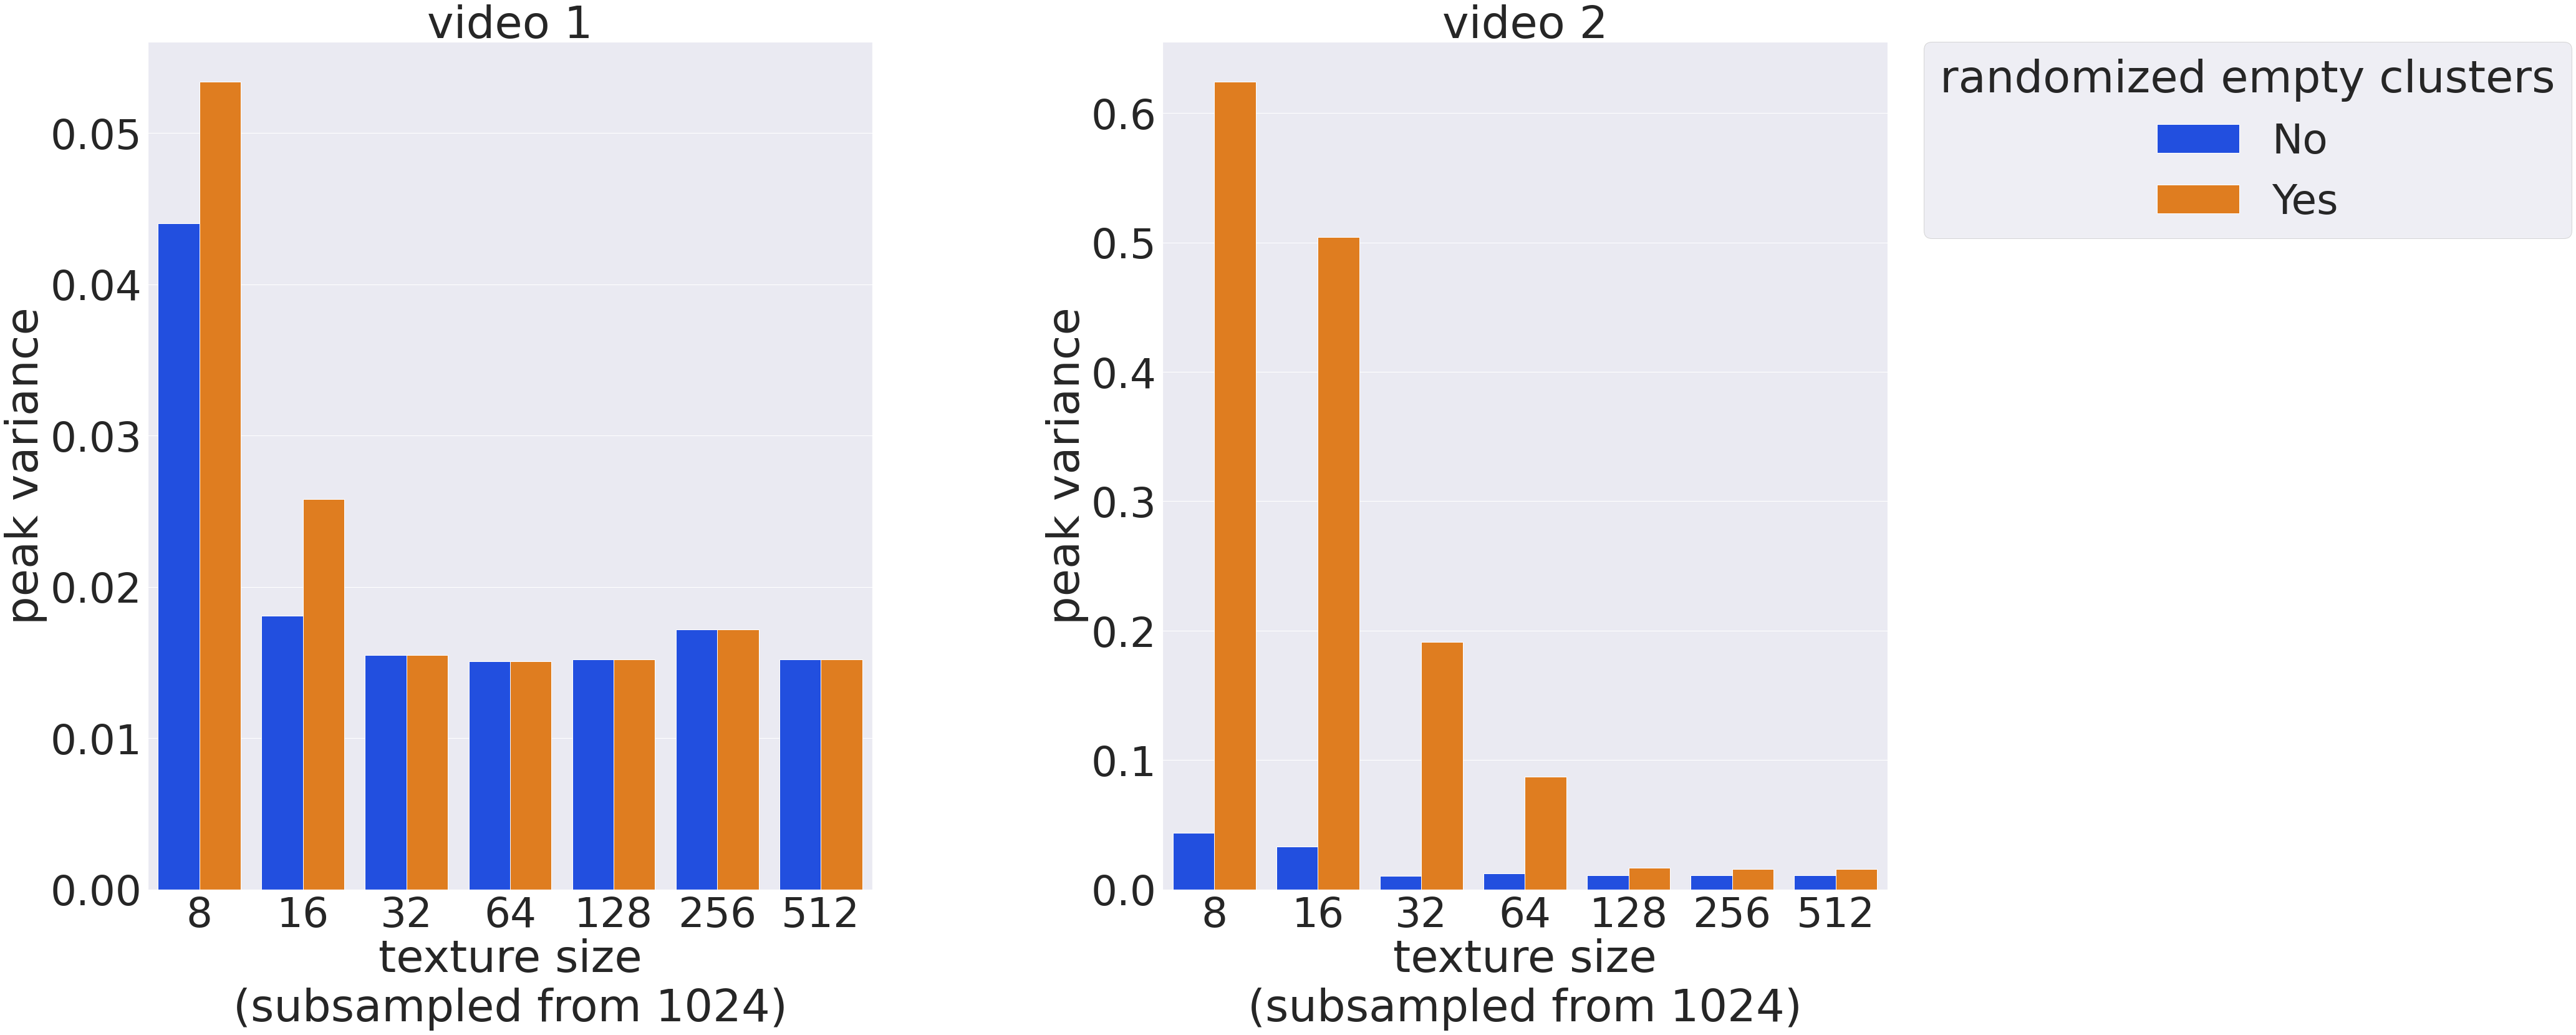

In [12]:
display(Markdown("## Plots"))

def randomized_empty_clusters_plots():

    def load_video(video_name):
        return pd.DataFrame(
            [
                (
                    int(measurement["settings"]["texture size"]),
                    measurement["total variance"],
                    measurement["peak variance"],
                    measurement["settings"]["randomize empty clusters"],
                )
                    for measurement in M5
                        if measurement["settings"]["video file"] == video_name
            ],
            columns=["texture size", "total variance", "peak variance", "randomized empty clusters"]
        )
    
    data = {
        f"video {video}" : load_video(video)
            for video in ["1", "2"]
    }
    
    def randomized_empty_clusters_variance_plots():

        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            x=data["video 1"]["texture size"],
            y=data["video 1"]["total variance"],
            ax=axes[0],
            hue=data["video 1"]["randomized empty clusters"],
            ci=None,
        )

        g.legend().remove()
        
        #g.set(yscale="log")

        axes[0].set_ylabel("variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            x=data["video 2"]["texture size"],
            y=data["video 2"]["total variance"],
            ax=axes[1],
            hue=data["video 2"]["randomized empty clusters"],
            ci=None,
        )

        axes[1].set_ylabel("variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="randomized empty clusters"
        )
        
        #g.set(yscale="log")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()

    def randomized_empty_clusters_peak_variance_plots():

        _, axes = plt.subplots(1, 2)

        g = sb.barplot(
            x=data["video 1"]["texture size"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["randomized empty clusters"],
            ci=None,
        )
        
        #g.set(yscale="log")

        g.legend().remove()

        
        #g.set(yscale="log")
        axes[0].set_ylabel("peak variance")
        axes[0].set_xlabel("texture size\n(subsampled from 1024)")
        axes[0].set_title("video 1")

        g = sb.barplot(
            x=data["video 2"]["texture size"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["randomized empty clusters"],
            ci=None,
        )

        axes[1].set_ylabel("peak variance")
        axes[1].set_xlabel("texture size\n(subsampled from 1024)")
        axes[1].set_title("video 2")

        g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="randomized empty clusters"
        )

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        #g.set(yscale="log")

        plt.show()

    randomized_empty_clusters_variance_plots()
    randomized_empty_clusters_peak_variance_plots()

randomized_empty_clusters_plots()

In [13]:
display(Markdown("# Dataset 6: KM, KHM, RS, Knecht"))

M6 = load_measurements("6. KM, KHM, RS, Knecht")

dummy_measurements = []
for measurement in M6:
    if (
        measurement["settings"]["algorithm"] == "Knecht"
        or measurement["settings"]["algorithm"] == "RS(2KM)_stop"
    ):
        dummy = copy.deepcopy(measurement)
        dummy["settings"]["number of iterations"] = str(30)
        dummy_measurements.append(
            dummy
        )

M6 = [
    measurement
        for collection in [M6, dummy_measurements]
        for measurement in collection
]

M6 = sorted(
    M6,
    key = lambda measurement: (
        int(measurement["settings"]["video file"]),
        int(measurement["settings"]["number of iterations"]),
        measurement["settings"]["algorithm"],
    )
)

show_measurements_table(M6)

# Dataset 6: KM, KHM, RS, Knecht

algorithm     |  video file  |  number of iterations  |  variance  |  peak variance
-------------------------------------------------------------------|----------------
KHM(3)        |  1           |  1                     |  0.00630   |0.01436   
KM            |  1           |  1                     |  0.00634   |0.01346   
Knecht        |  1           |  1                     |  0.00587   |0.01055   
RS(2KM)_stop  |  1           |  1                     |  0.00586   |0.01049   
KHM(3)        |  1           |  2                     |  0.00619   |0.01456   
KM            |  1           |  2                     |  0.00622   |0.01302   
KHM(3)        |  1           |  3                     |  0.00612   |0.01243   
KM            |  1           |  3                     |  0.00621   |0.01298   
RS(2KM)       |  1           |  3                     |  0.00593   |0.01192   
KHM(3)        |  1           |  4                     |  0.00611   |0.01229   
KM            |  1           |  4        

## Plots

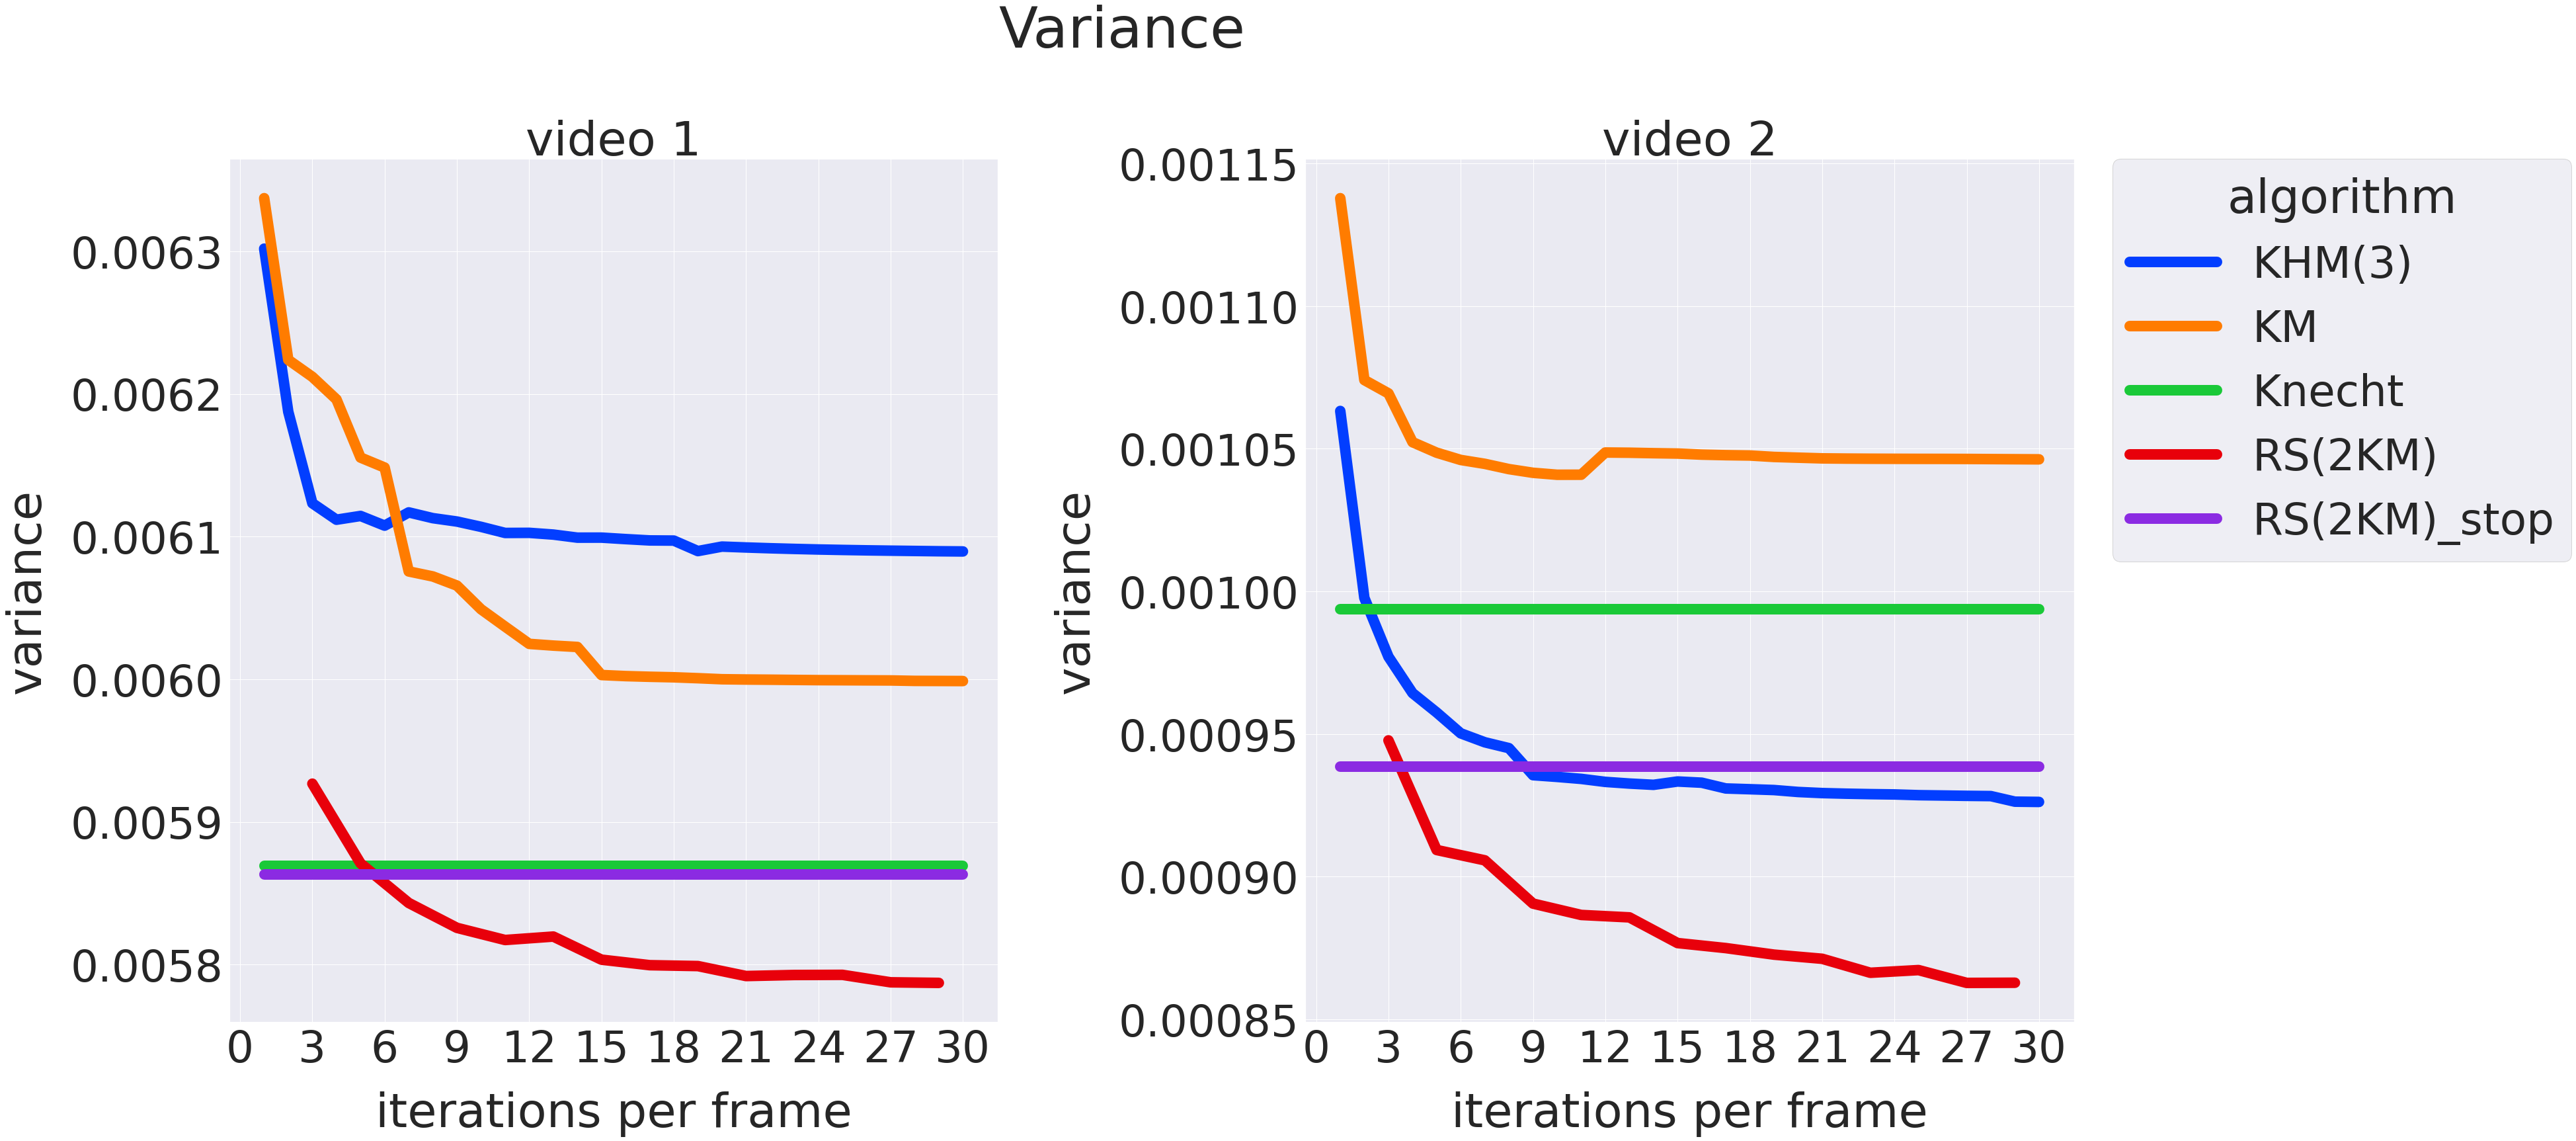

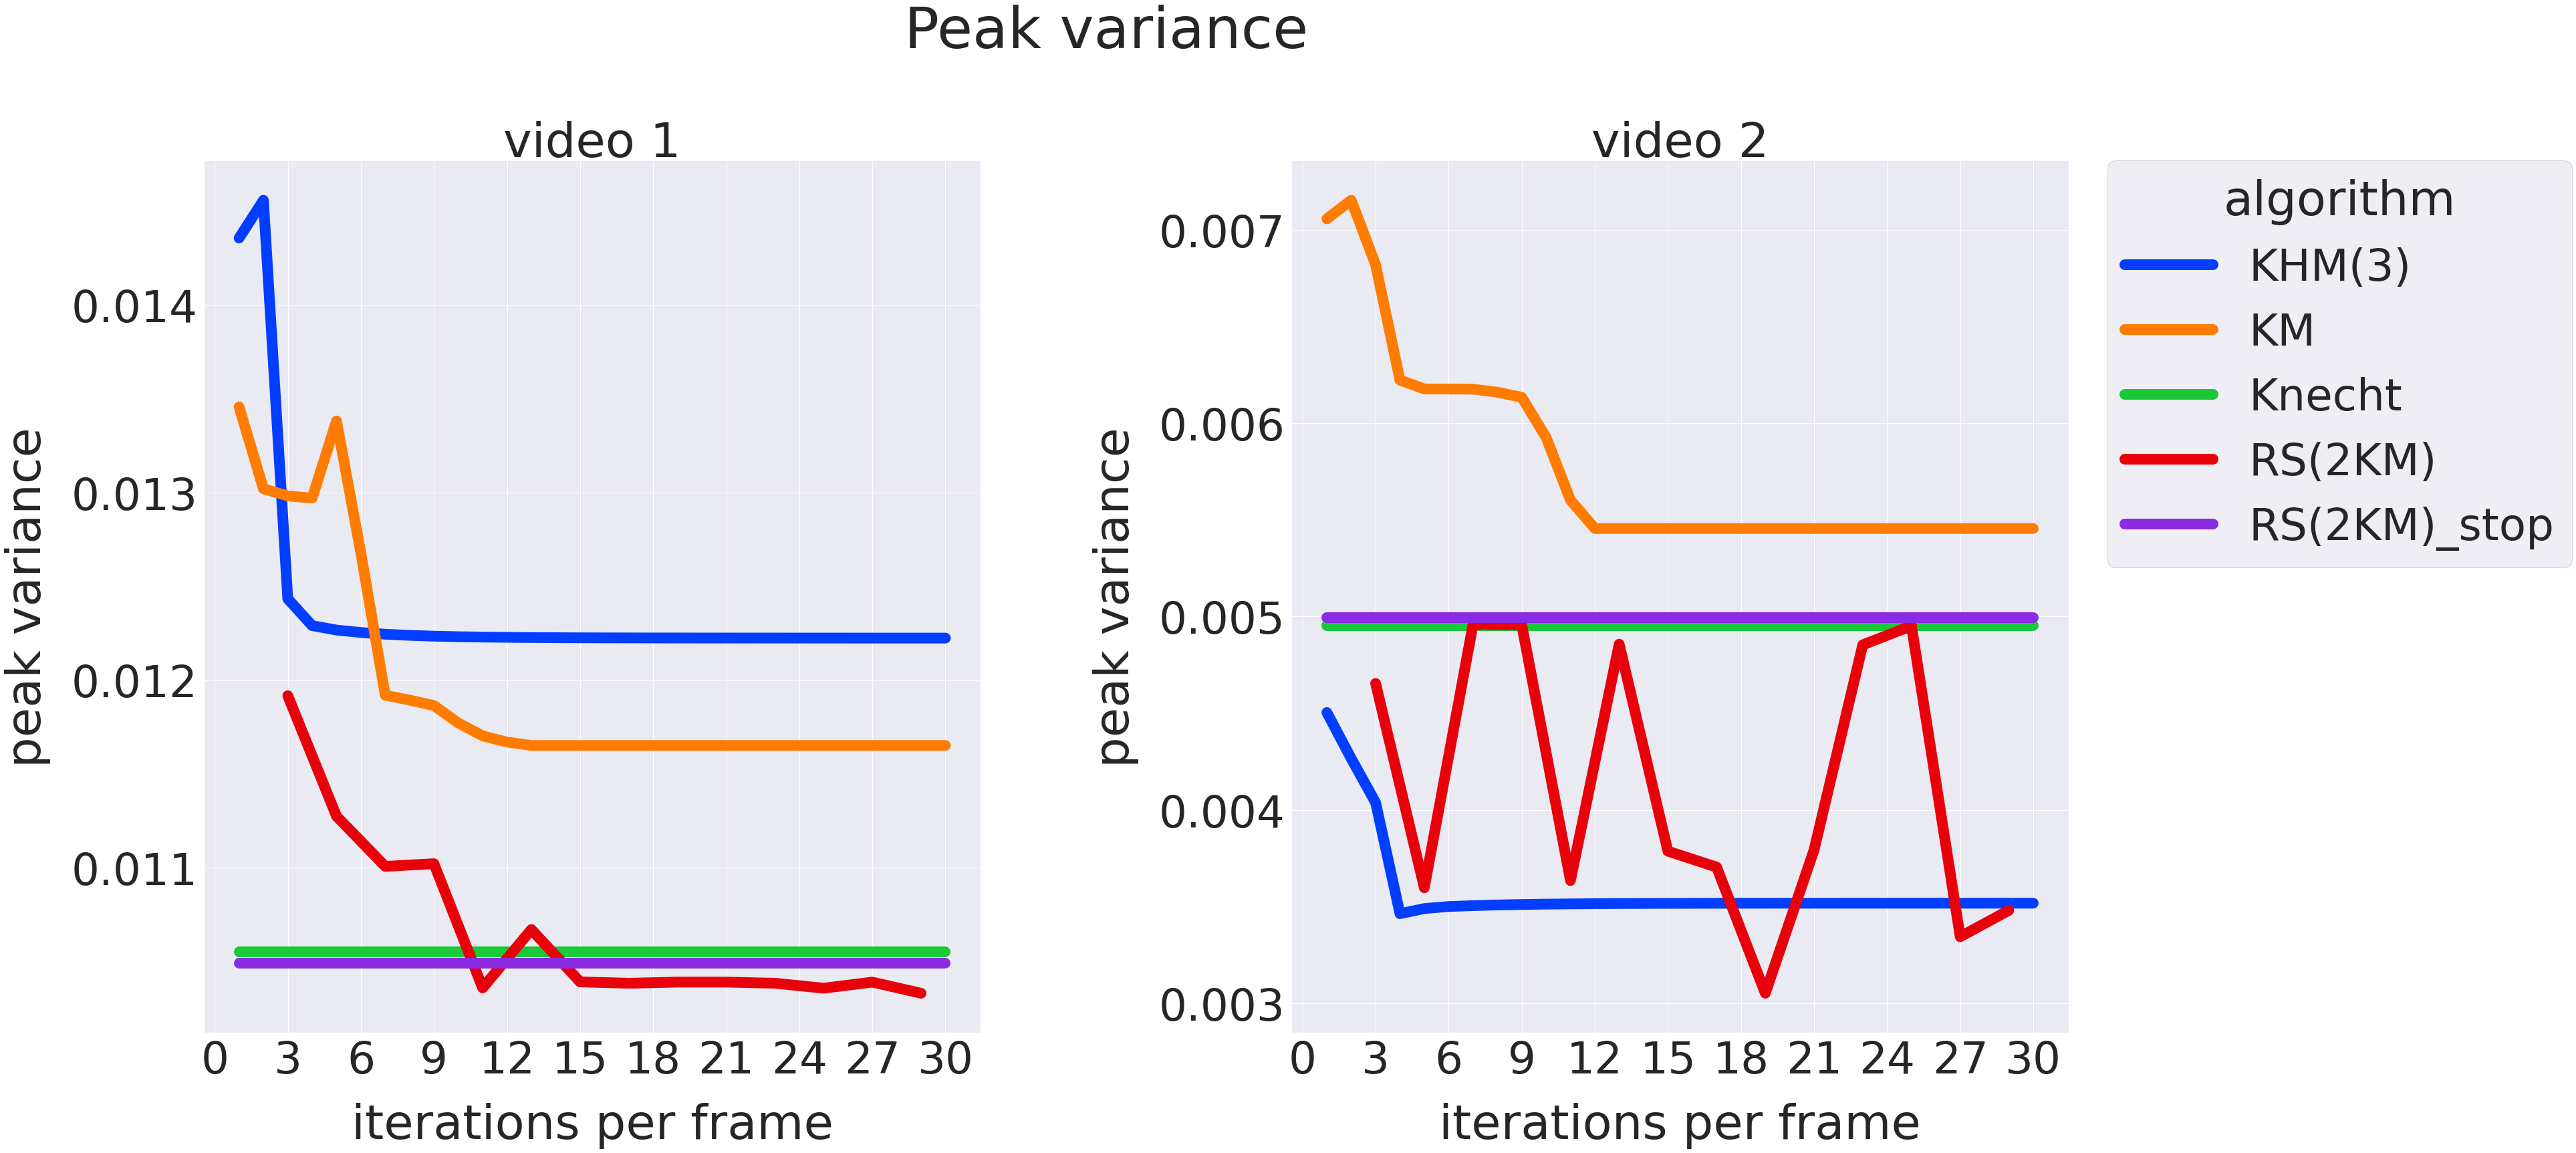

## Knecht variance

           video: 1
        variance: 0.0059
   peak variance: 0.011
number of iterations: 1

           video: 1
        variance: 0.0059
   peak variance: 0.011
number of iterations: 30

           video: 2
        variance: 0.00099
   peak variance: 0.005
number of iterations: 1

           video: 2
        variance: 0.00099
   peak variance: 0.005
number of iterations: 30



Comparable to 2 iterations of KM in terms of both variance and peak variance

In [14]:
display(Markdown("## Plots"))

def algorithms_plot():
    LINE_WIDTH = 16
    
    def load_video(video, measurements):
            return pd.DataFrame(
                [
                    (
                        measurement["settings"]["algorithm"],
                        measurement["total variance"],
                        measurement["peak variance"],
                        int(measurement["settings"]["number of iterations"]),
                    )
                        for measurement in sorted(M6, key = lambda measurement: measurement["settings"]["algorithm"])
                            if measurement["settings"]["video file"] == video.split(" ")[-1]
                            #and measurement["settings"]["algorithm"] != "Knecht"
                ],
                columns=["algorithm", "total variance", "peak variance", "number of iterations"]
            )

    data = {
        f"video {video}" : load_video(video, M6)
            for video in ["1", "2"]
    }
    
    def variance_plot():
        max_num_iterations = max(data["video 2"]["number of iterations"])
        num_ticks = 10
        xticks = [x*max_num_iterations // num_ticks for x in range(num_ticks+1)]        
        
        fig, axes = plt.subplots(1, 2)
        fig.suptitle("Variance")
        fig.subplots_adjust(top=.85)
        
        axes[1].set_xticks(xticks)
        axes[0].set_xticks(xticks)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["total variance"],
            hue=data["video 1"]["algorithm"],
            ax=axes[0],
            ci=None,
            linewidth = LINE_WIDTH,
            palette="bright",
            #marker="o",
        )

        axes[0].set_ylabel("variance", labelpad=LABELPAD)
        axes[0].set_xlabel("iterations per frame", labelpad=LABELPAD)
        axes[0].set_title("video 1")
        
        g.legend().remove()
        
        #g.set(yscale="log")

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["total variance"],
            hue=data["video 2"]["algorithm"],
            ax=axes[1],
            ci=None,
            linewidth = LINE_WIDTH,
            palette="bright",
            #marker="o",
        )

        axes[1].set_ylabel("variance", labelpad=LABELPAD)
        axes[1].set_xlabel("iterations per frame", labelpad=LABELPAD)
        axes[1].set_title("video 2")
        
        legend = g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="algorithm"
        )
        
        for line in legend.get_lines():
            line.set_linewidth(LINE_WIDTH)
        
        #g.set(yscale="log")

        plt.subplots_adjust(
            wspace=0.4,
        )

        plt.show()
    
    def peak_variance_plot():
        max_num_iterations = max(data["video 2"]["number of iterations"])
        num_ticks = 10
        xticks = [x*max_num_iterations // num_ticks for x in range(num_ticks+1)]
        
        fig, axes = plt.subplots(1, 2)
        fig.suptitle("Peak variance")
        fig.subplots_adjust(top=.85)
        
        axes[1].set_xticks(xticks)
        axes[0].set_xticks(xticks)

        g = sb.lineplot(
            x=data["video 1"]["number of iterations"],
            y=data["video 1"]["peak variance"],
            ax=axes[0],
            hue=data["video 1"]["algorithm"],
            ci=None,
            linewidth = LINE_WIDTH,
            palette="bright",
            #marker="o",
        )

        axes[0].set_ylabel("peak variance", labelpad=LABELPAD)
        axes[0].set_xlabel("iterations per frame", labelpad=LABELPAD)
        axes[0].set_title("video 1")
        
        g.legend().remove()
        
        #g.set(yscale="log")

        g = sb.lineplot(
            x=data["video 2"]["number of iterations"],
            y=data["video 2"]["peak variance"],
            ax=axes[1],
            hue=data["video 2"]["algorithm"],
            ci=None,
            linewidth = LINE_WIDTH,
            palette="bright",
            #marker="o",
        )

        axes[1].set_ylabel("peak variance", labelpad=LABELPAD)
        axes[1].set_xlabel("iterations per frame", labelpad=LABELPAD)
        axes[1].set_title("video 2")

        plt.subplots_adjust(
            wspace=0.4,
        )
        
        legend = g.legend(
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0,
            title="algorithm",
        )
        
        for line in legend.get_lines():
            line.set_linewidth(LINE_WIDTH)
        
        
        #g.set(yscale="log")

        plt.show()
        
    variance_plot()
    peak_variance_plot()
    
algorithms_plot()

display(Markdown("## Knecht variance"))

for measurement in M6:
    if measurement["settings"]["algorithm"] != "Knecht":
        continue
    stats = {
        "video" : measurement["settings"]["video file"],
        "variance" : f"{measurement['total variance']:0.2}",
        "peak variance" : f"{measurement['peak variance']:0.2}",
        "number of iterations": measurement["settings"]["number of iterations"]
    }
    for stat_name in stats:
        print(f"{stat_name:>16}: {stats[stat_name]}")
    print()
    
display(Markdown("Comparable to 2 iterations of KM in terms of both variance and peak variance"))

In [15]:
display(
    Markdown(
"""
# PSO

PSO has similar complexity to K-Means, but:
* converges faster
* requires batches of "KM iterations" (batch size = number of particles)

given that we can get away with a single iteration of KM per frame, PSO is not very useful

## Number of clusters

Determining the number of clusters with PSO is a potential significant benefit

### DCPSO

*[2005] Dynamic clustering using particle swarm optimization with
application in image segmentation*

PSO is used to determine optimal ilitialization for ordinary KM, potentionally quite fast.
The best part is that KM code can be left as-is, and PSO initialization built on top of it later.
Leave it for the future work.

But check more recent papers referensing DCPSO.
"""
    )
)


# PSO

PSO has similar complexity to K-Means, but:
* converges faster
* requires batches of "KM iterations" (batch size = number of particles)

given that we can get away with a single iteration of KM per frame, PSO is not very useful

## Number of clusters

Determining the number of clusters with PSO is a potential significant benefit

### DCPSO

*[2005] Dynamic clustering using particle swarm optimization with
application in image segmentation*

PSO is used to determine optimal ilitialization for ordinary KM, potentionally quite fast.
The best part is that KM code can be left as-is, and PSO initialization built on top of it later.
Leave it for the future work.

But check more recent papers referensing DCPSO.


In [16]:
display(Markdown("# KM vs KHM"))

# KM vs KHM

In [17]:
display(Markdown("## KHM(p)"))

def show_KHM_p_measurement():
    Mp = load_measurements(f"KHM(p)")

    Mp = sorted(
        Mp,
        key = lambda measurement: (
            int(measurement["settings"]["video file"]),
        )
    )
    
    show_measurements_table(Mp)
    print("\n")

show_KHM_p_measurement()

## KHM(p)

algorithm  |  video file  |  variance  |  peak variance
---------------------------------------|----------------
KHM(2)     |  1           |  0.00792   |0.01737   
KHM(3)     |  1           |  0.00767   |0.01537   
KHM(3.5)   |  1           |  0.00850   |0.01543   
KHM(2)     |  2           |  0.00146   |0.08707   
KHM(3)     |  2           |  0.00122   |0.12075   
KHM(3.5)   |  2           |  0.00902   |0.78524   




## Per-frame KM vs KHM

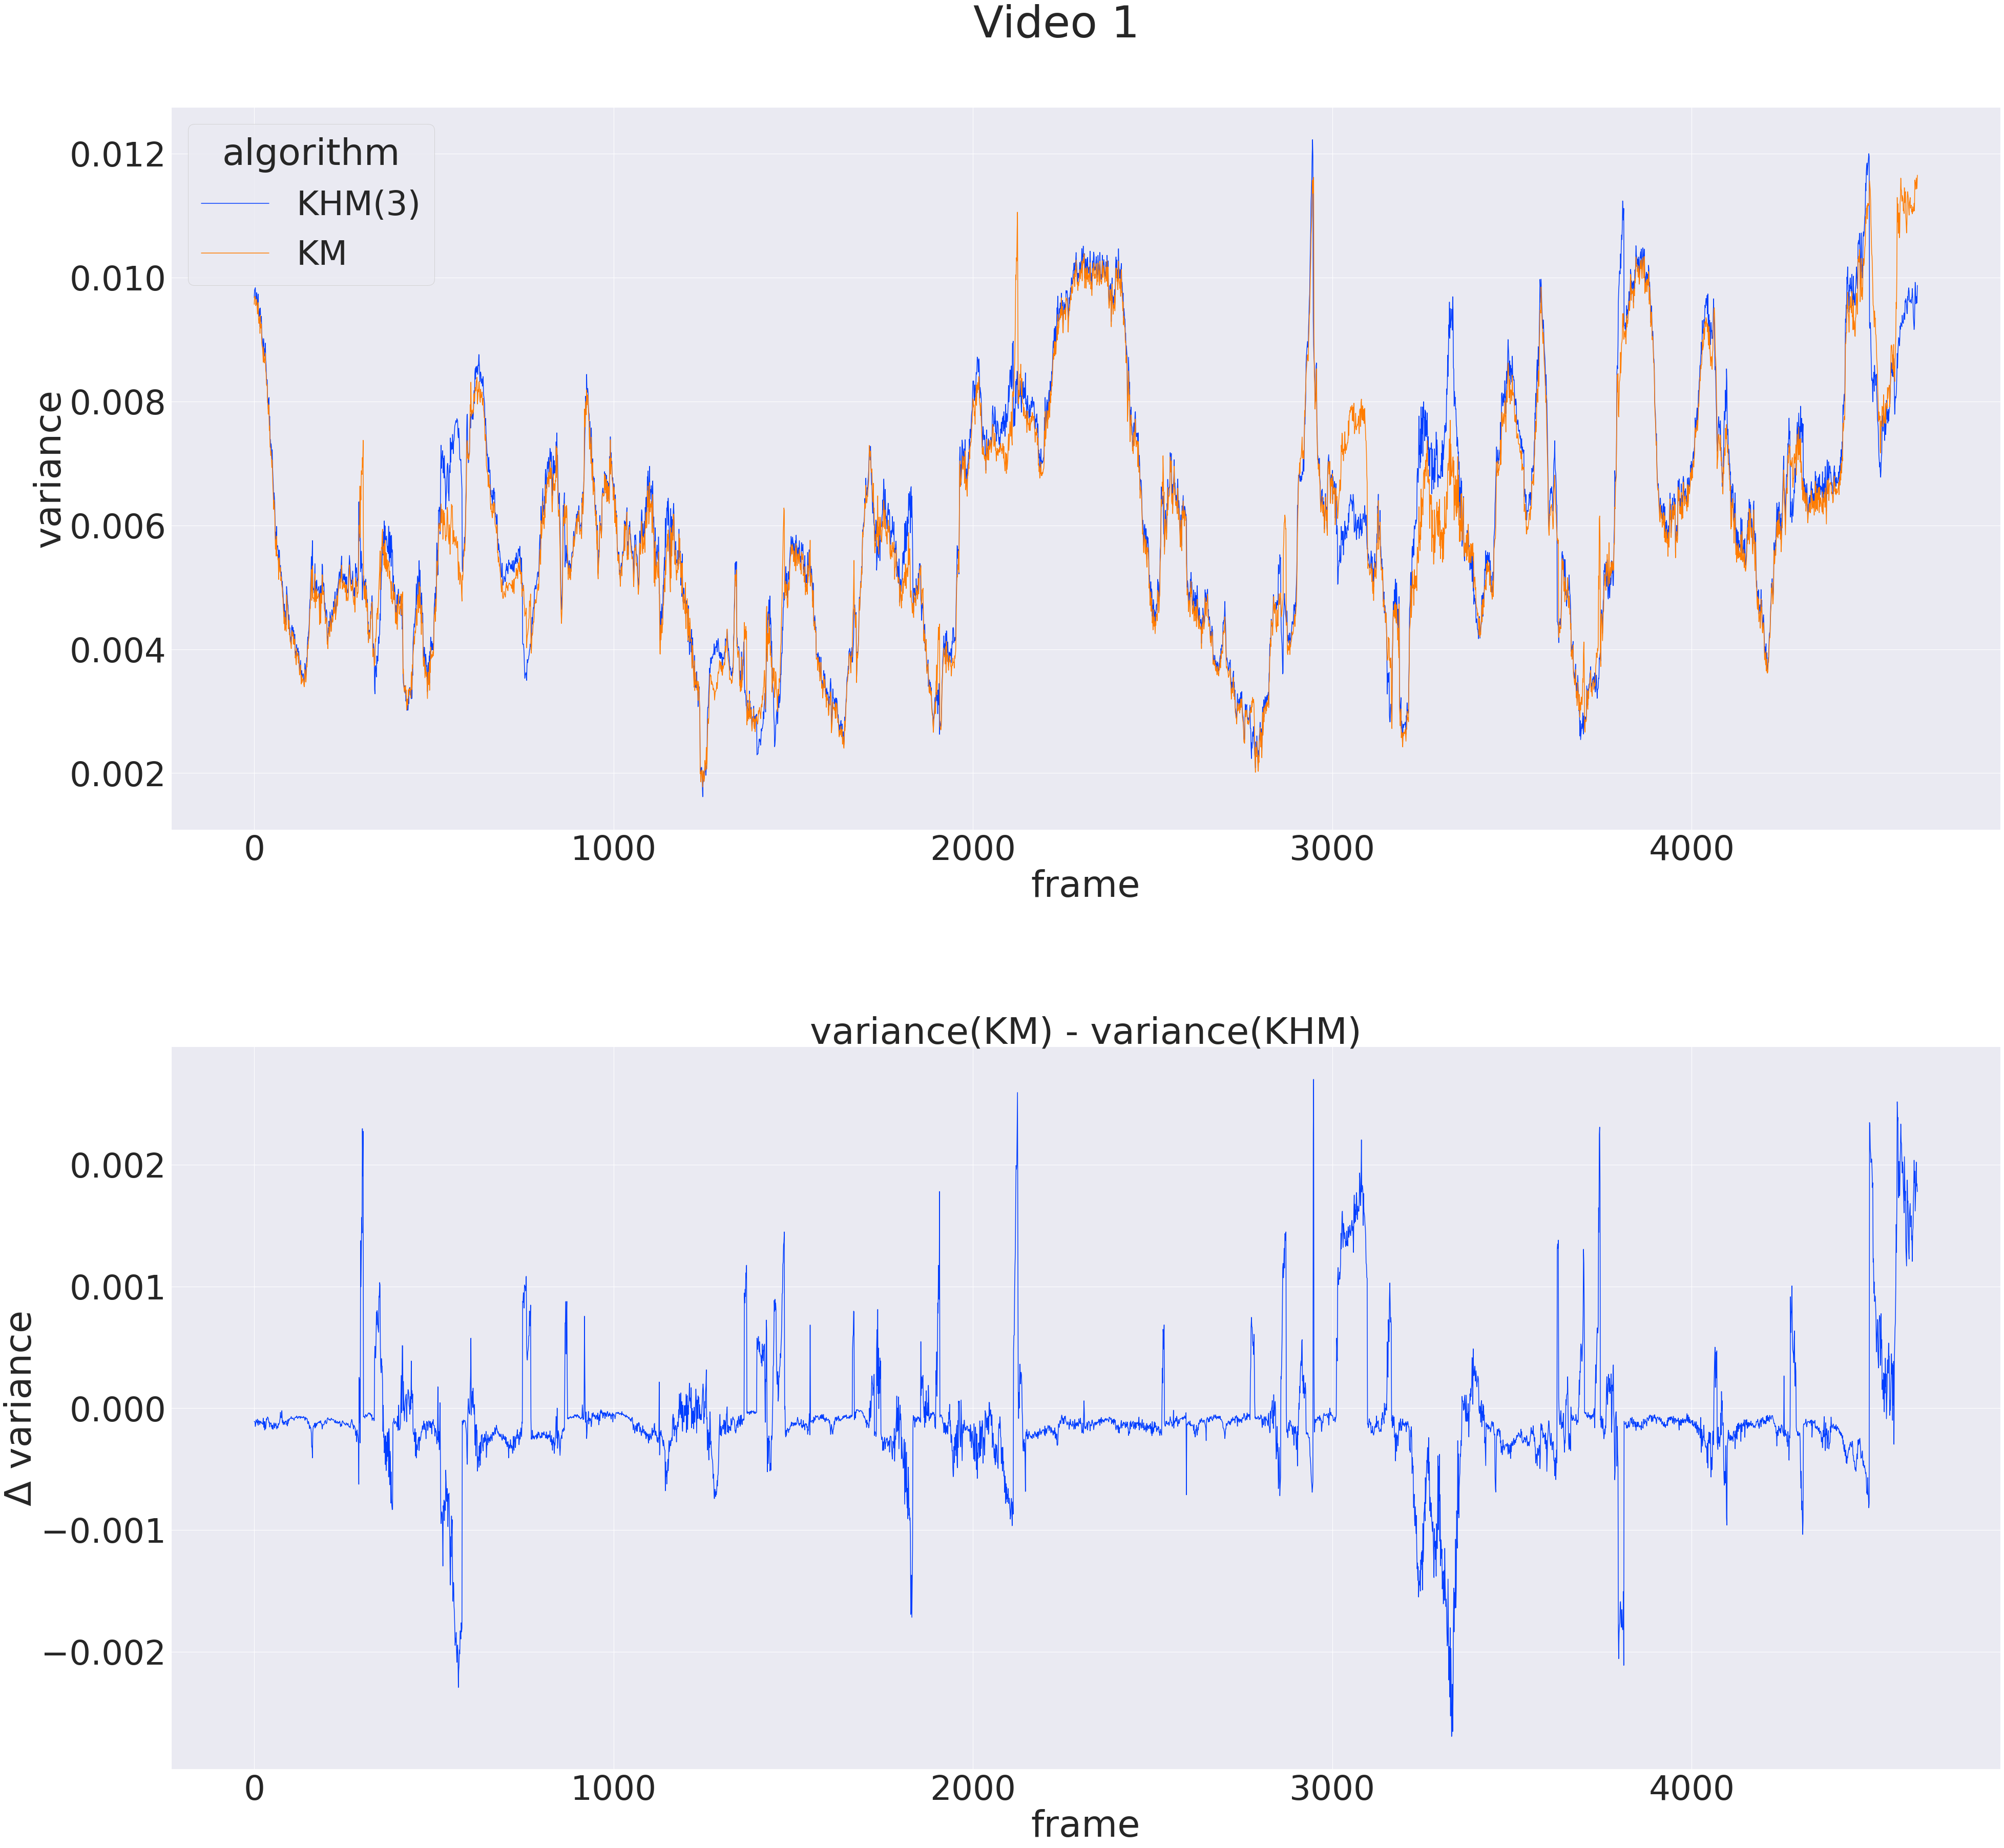

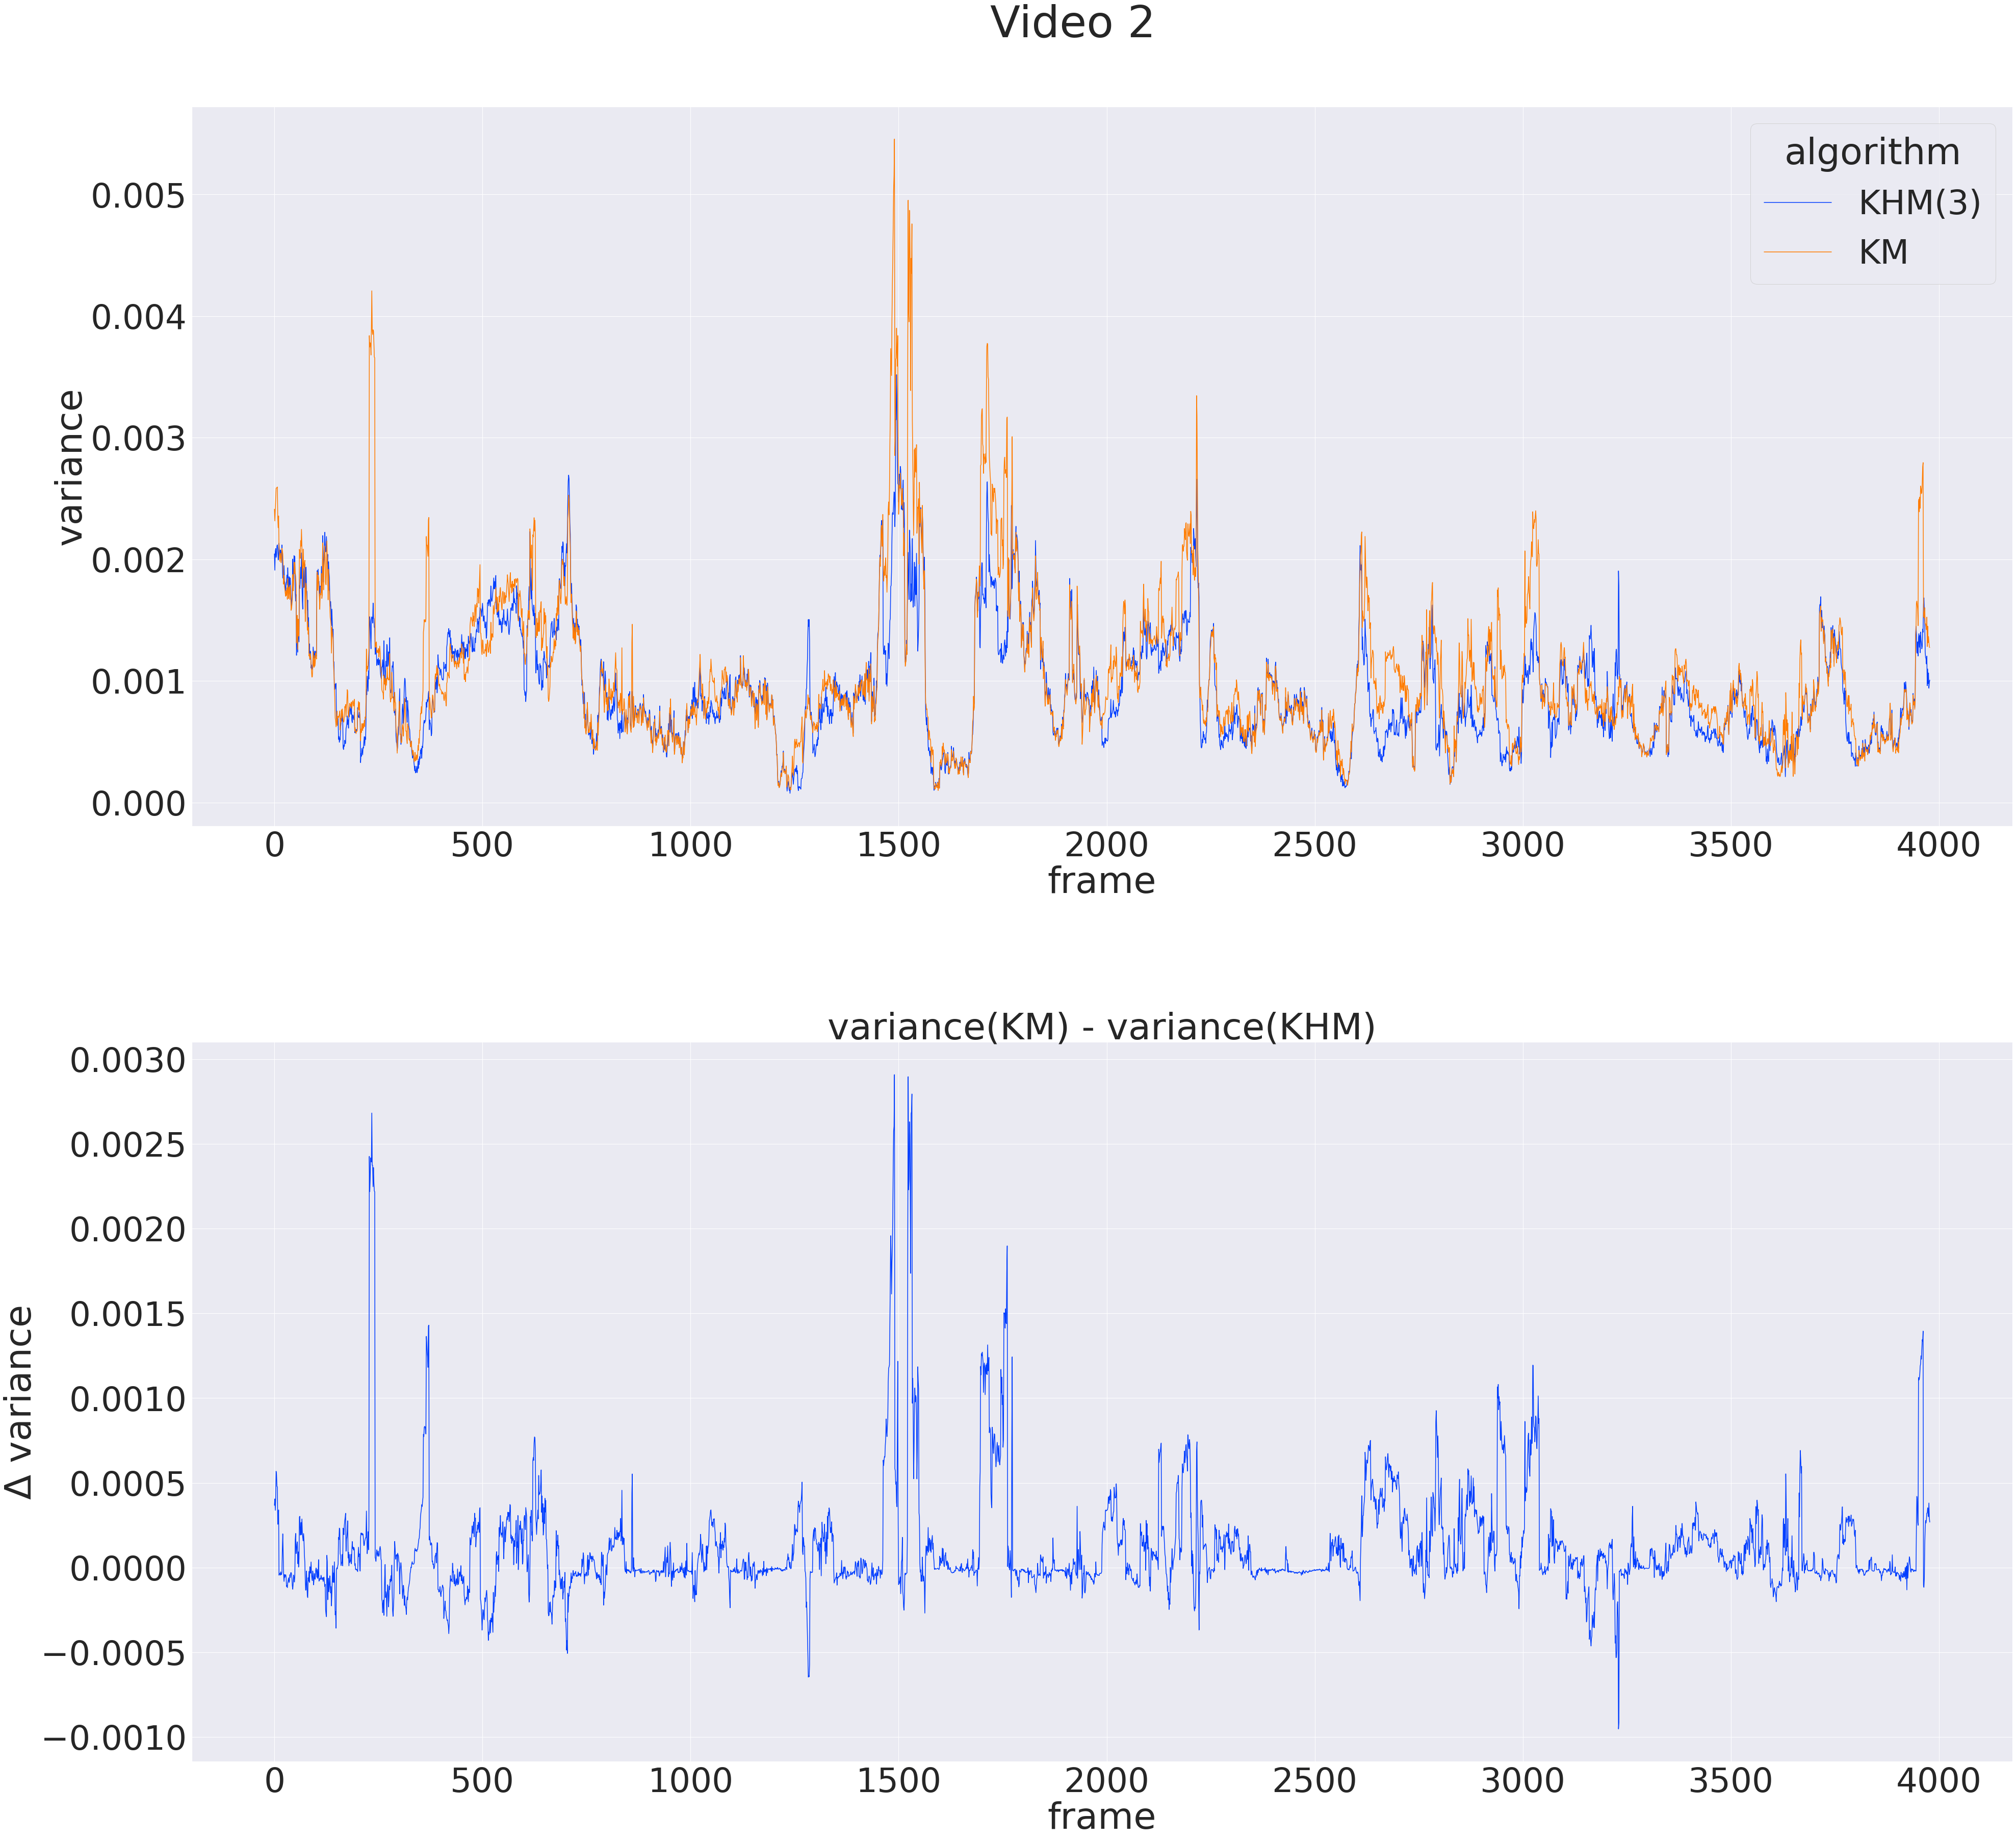

In [18]:
display(Markdown("## Per-frame KM vs KHM"))

def plot_per_frame(video):
    data = pd.DataFrame(
        [
            line
            for measurement_data in [
                list(
                    zip(
                        [algorithm for i in range(len(variances))],
                        [i for i in range(len(variances))],
                        variances
                    )
                )
                for algorithm, variances in [
                    (
                        measurement["settings"]["algorithm"],
                        measurement["variance"]
                    )
                    for measurement in M6
                        if measurement["settings"]["number of iterations"] == "30"
                            and measurement["settings"]["video file"] == video
                            and measurement["settings"]["algorithm"] in ["KM", "KHM(3)"]
                ]
            ]
            for line in measurement_data
        ],
        columns=["algorithm", "frame", "variance"]
    )
    
    fig, ax = plt.subplots(2,1, figsize=(64,56))
    
    sb.lineplot(
        x=data["frame"],
        y=data["variance"],
        hue=data["algorithm"],
        ci=None,
        ax=ax[0]
    )
    
    #ax[0].set_title("per-frame variance")
    
    data_km = data[data["algorithm"].isin(["KM"])].reset_index()
    data_khm = data[data["algorithm"].isin(["KHM(3)"])].reset_index()
    
    data_diff = data_km.copy()
    del data_diff["algorithm"]
    data_diff["variance"] = [
        data_km.loc[i, "variance"] - data_khm.loc[i, "variance"]
        for i in range(len(data_km["variance"]))
    ]
    
    sb.lineplot(
        x=data_diff["frame"],
        y=data_diff["variance"],
        ci=None,
        ax=ax[1]
    )
    
    ax[1].set_title("variance(KM) - variance(KHM)")
    ax[1].set_ylabel("Δ variance")
    
    fig.suptitle(f"Video {video}")
    
    plt.subplots_adjust(
        hspace=0.3,
        top=0.93
    )
    
    plt.show()
        
plot_per_frame("1")
plot_per_frame("2")

# Frame time analysis

## IL2CPP build

   complete runs: 5
settings per run: 32

video file | texture size | number of iterations | algorithm            | frame time | peak frame time
------------------------------------------------------------------------------------------
1          | 512          | 1                    | KHM(3)               | 1.35       | 1.49           
1          | 512          | 1                    | KM                   | 1.36       | 1.47           
1          | 512          | 3                    | KHM(3)               | 2.54       | 2.65           
1          | 512          | 3                    | KM                   | 2.54       | 2.64           
1          | 512          | 3                    | RS(2KM)              | 2.55       | 2.67           
1          | 512          | 3                    | RS(2KM)_readback     | 3.19       | 3.38           
1          | 512          | N/a                  | Knecht               | 3.88       | 11.4           
1          | 512          | N/a            

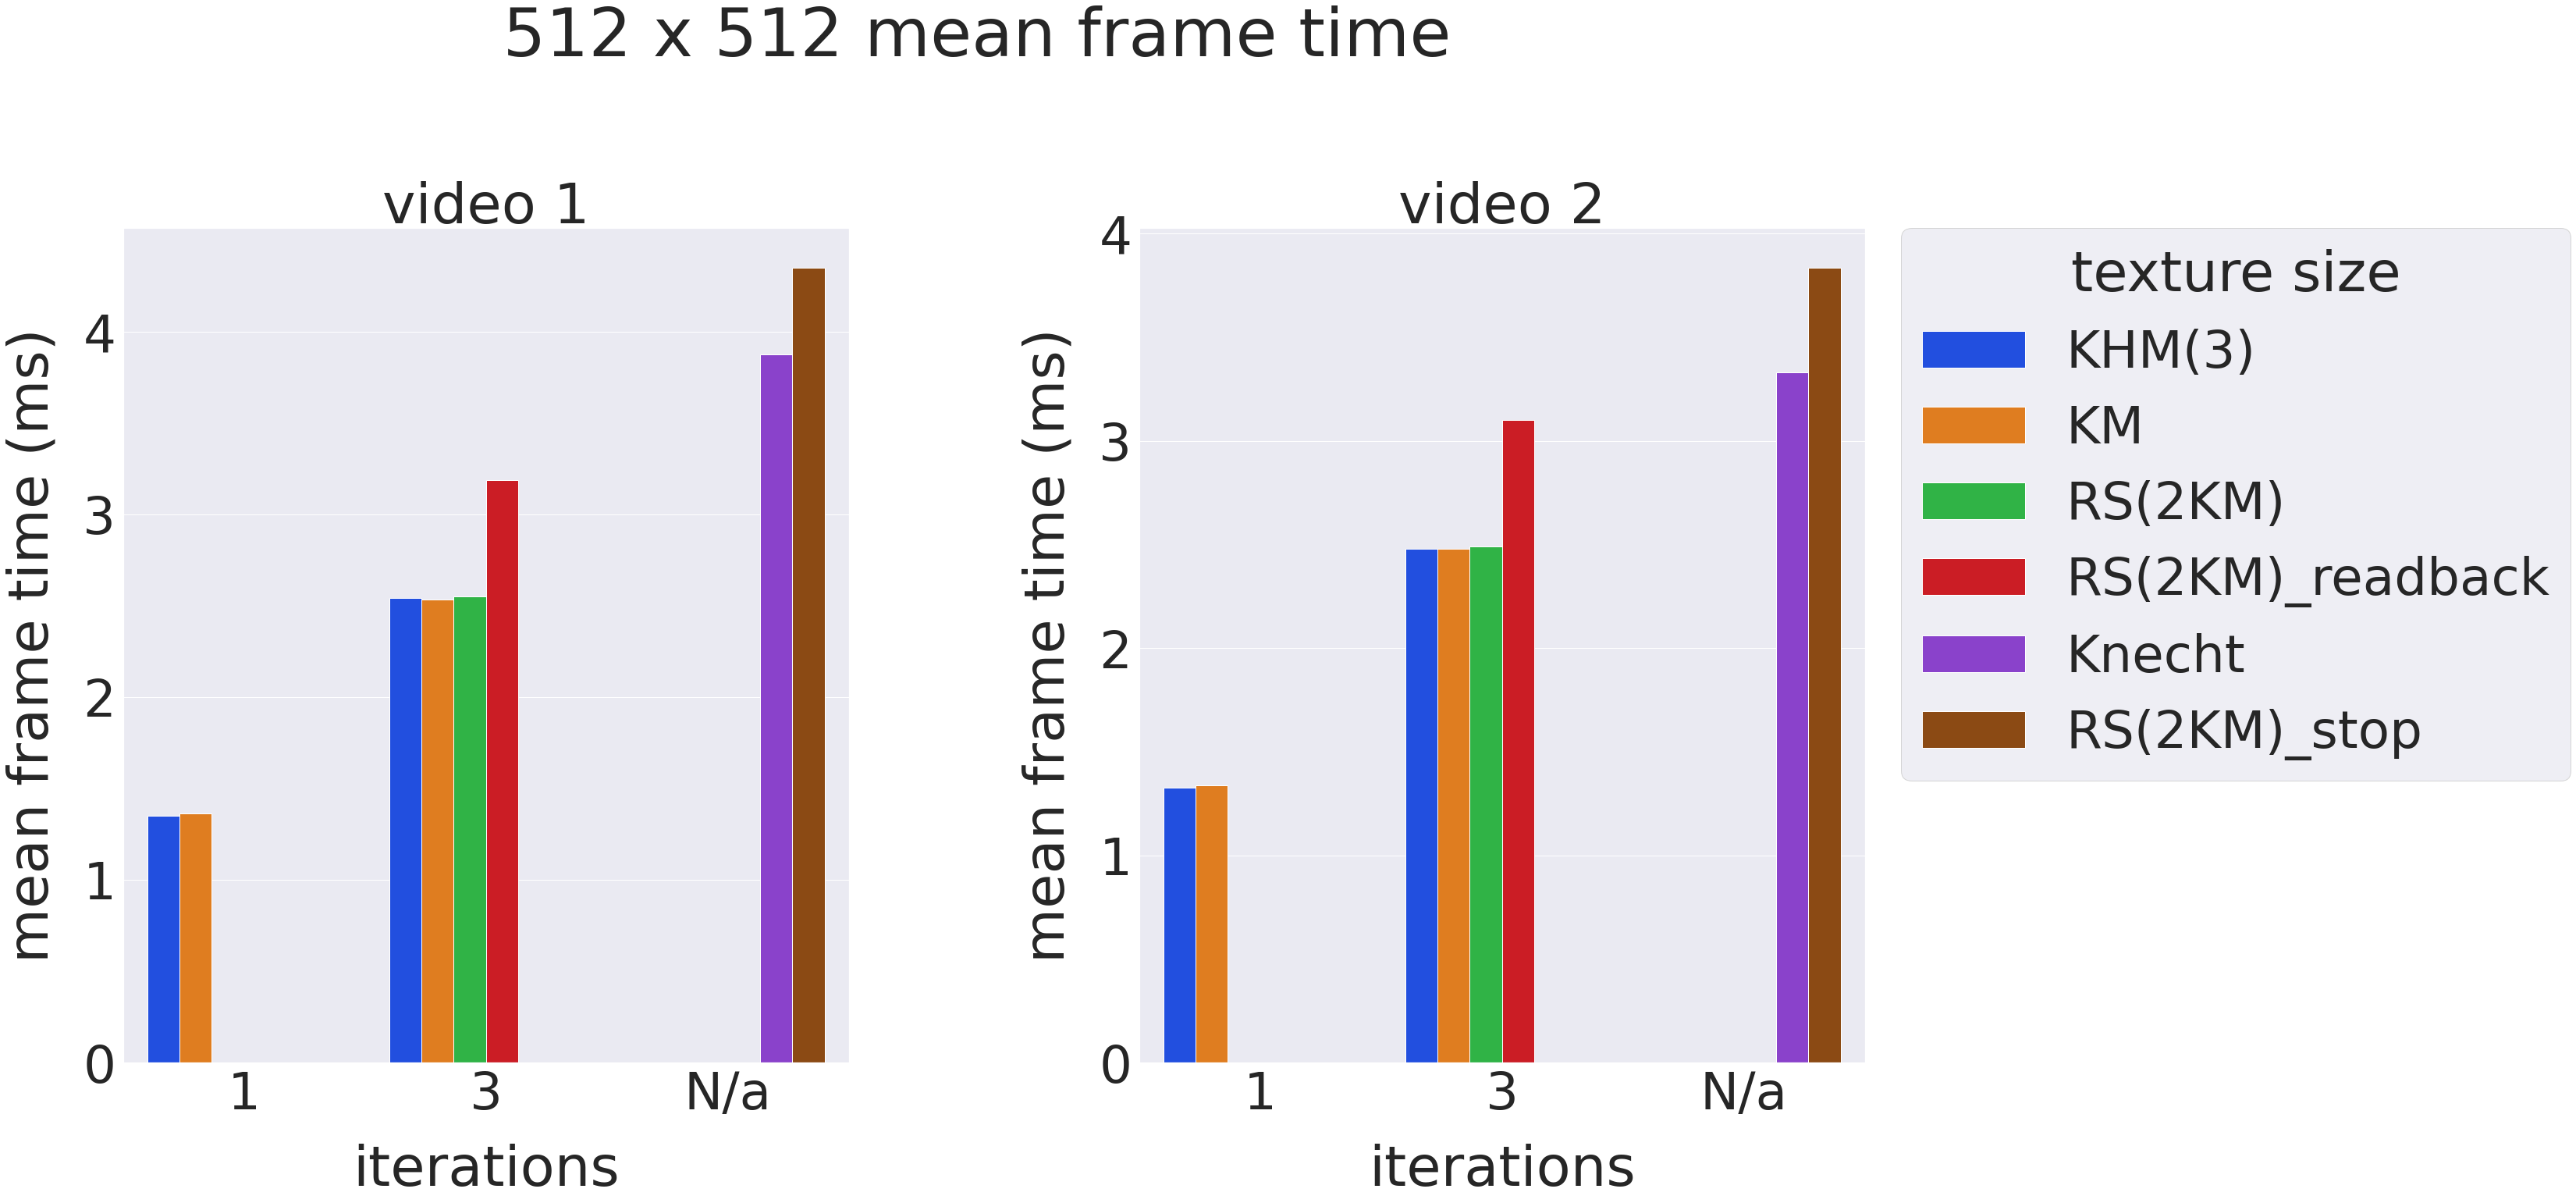

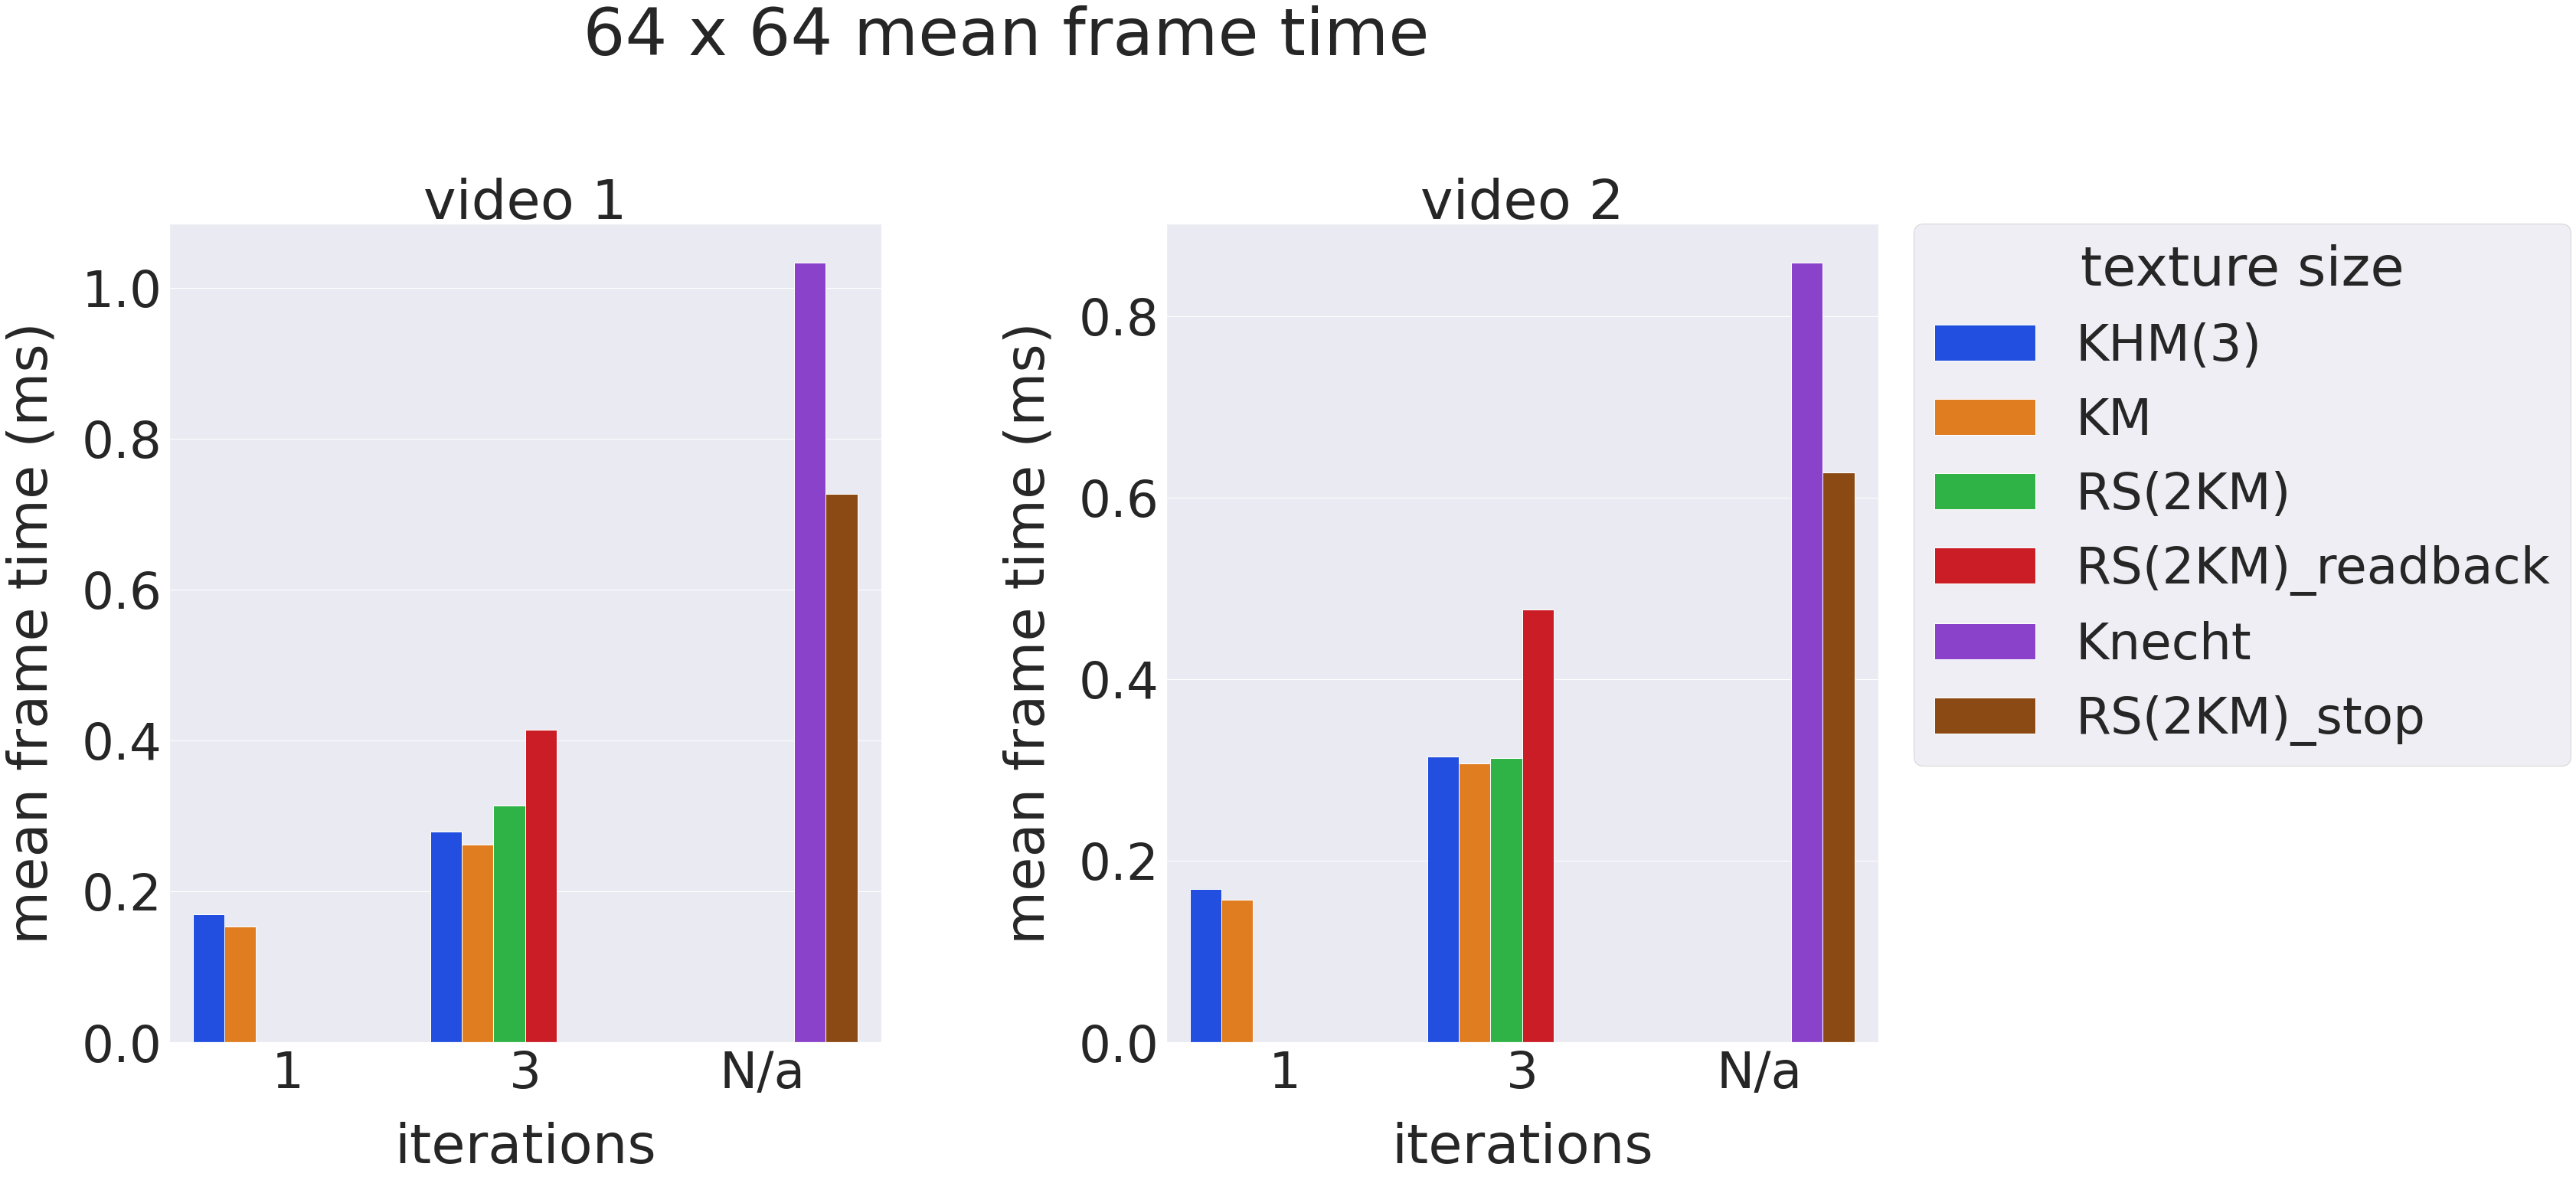

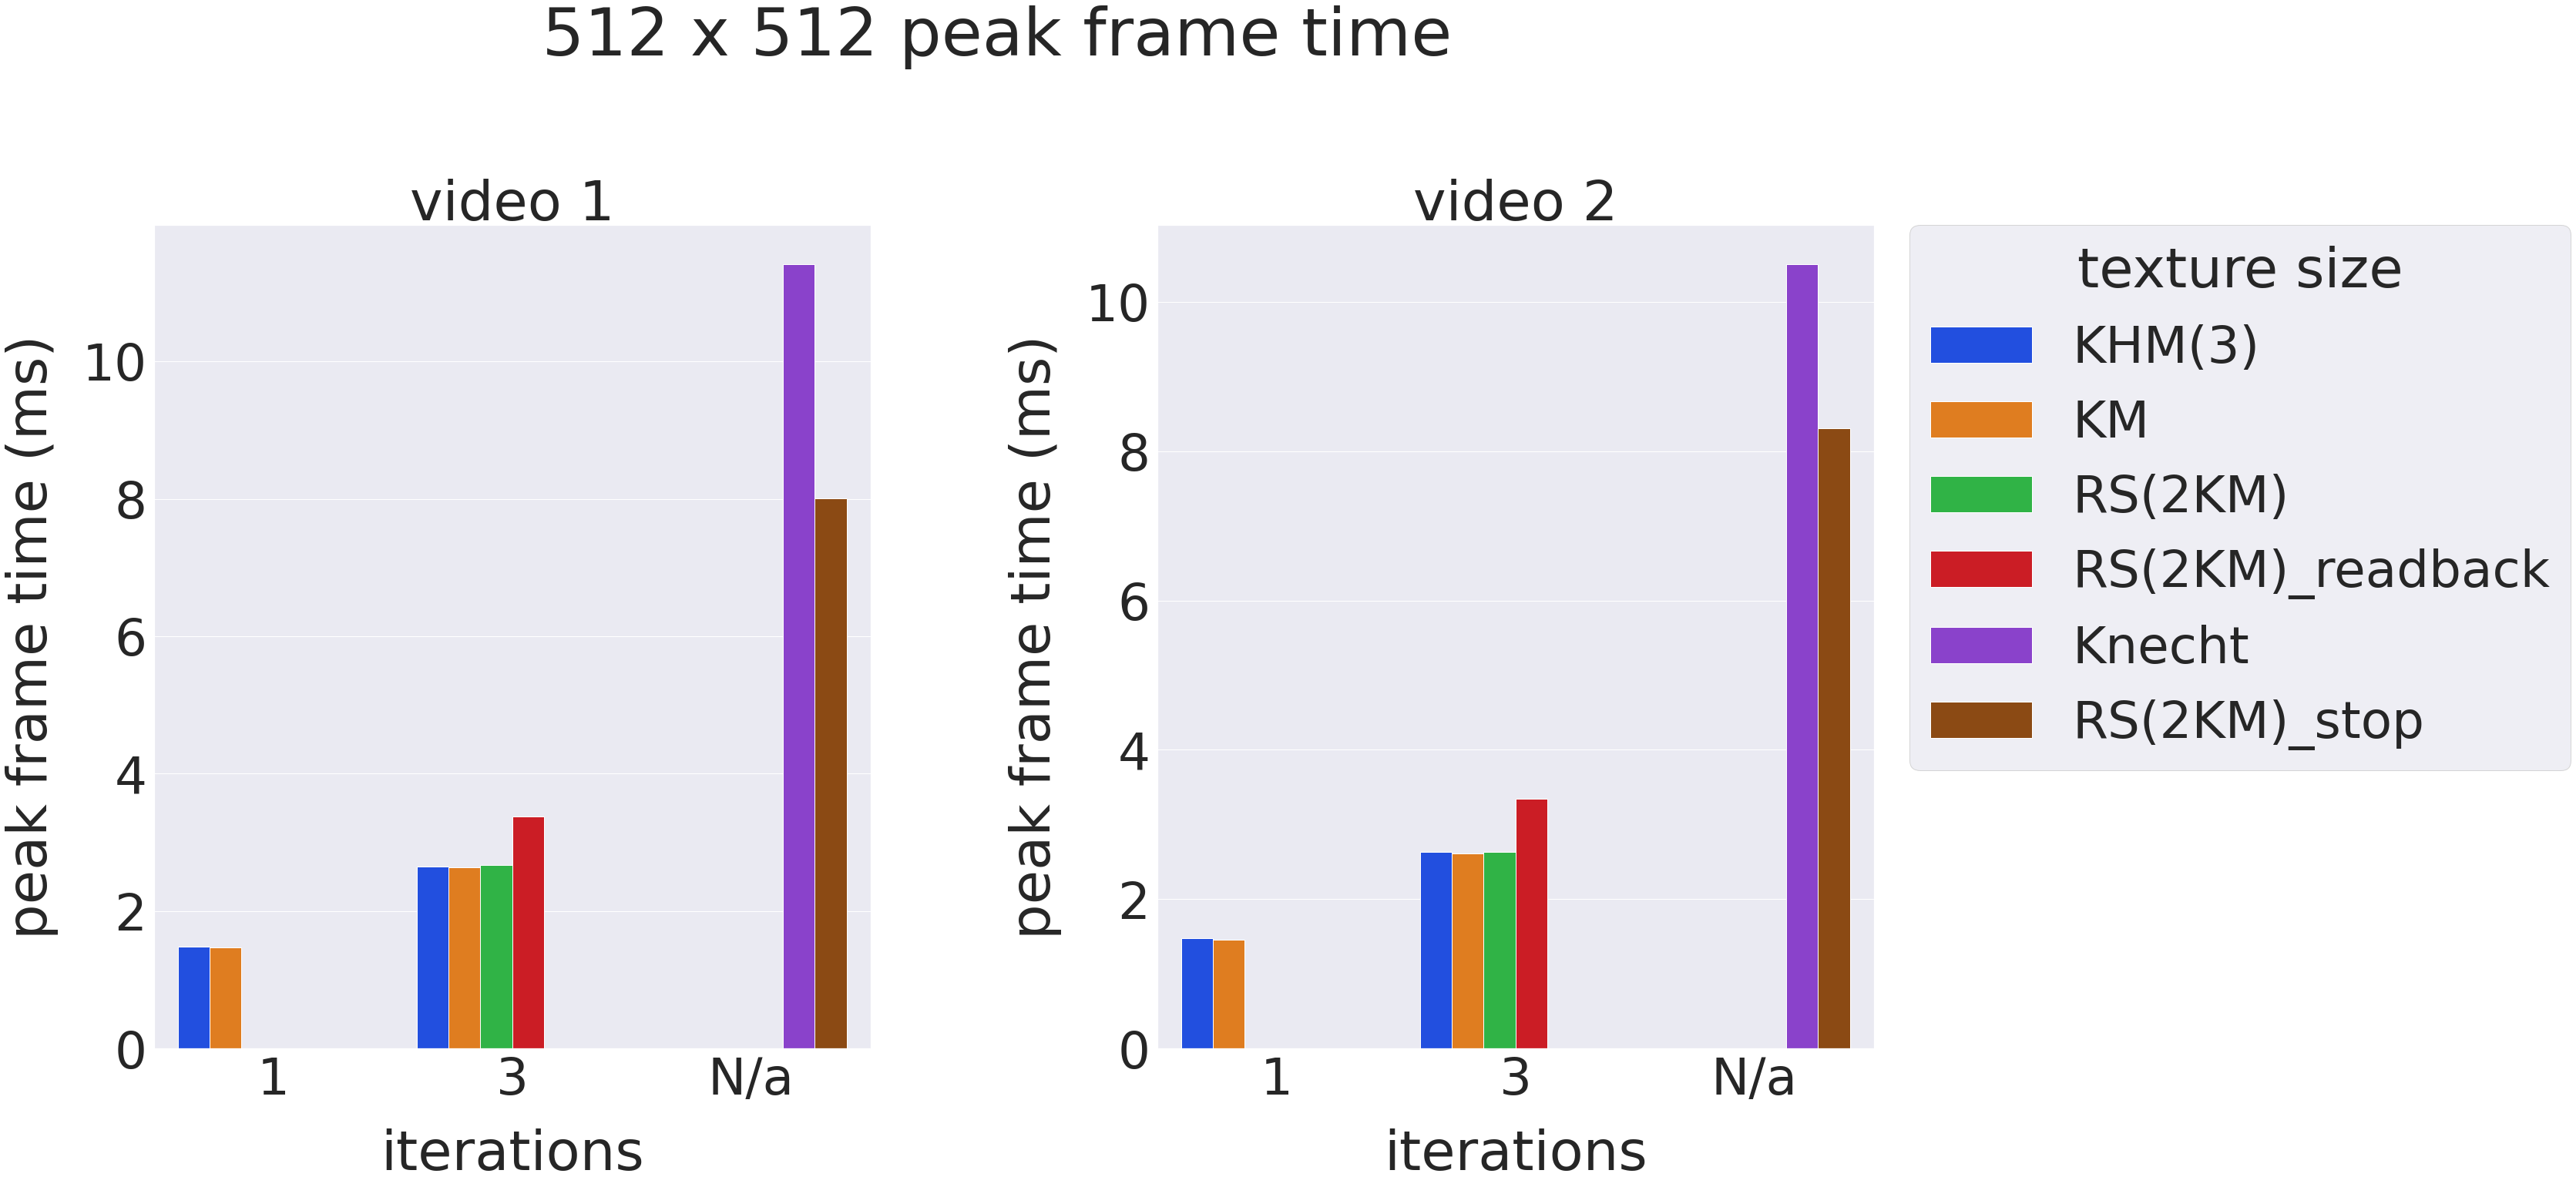

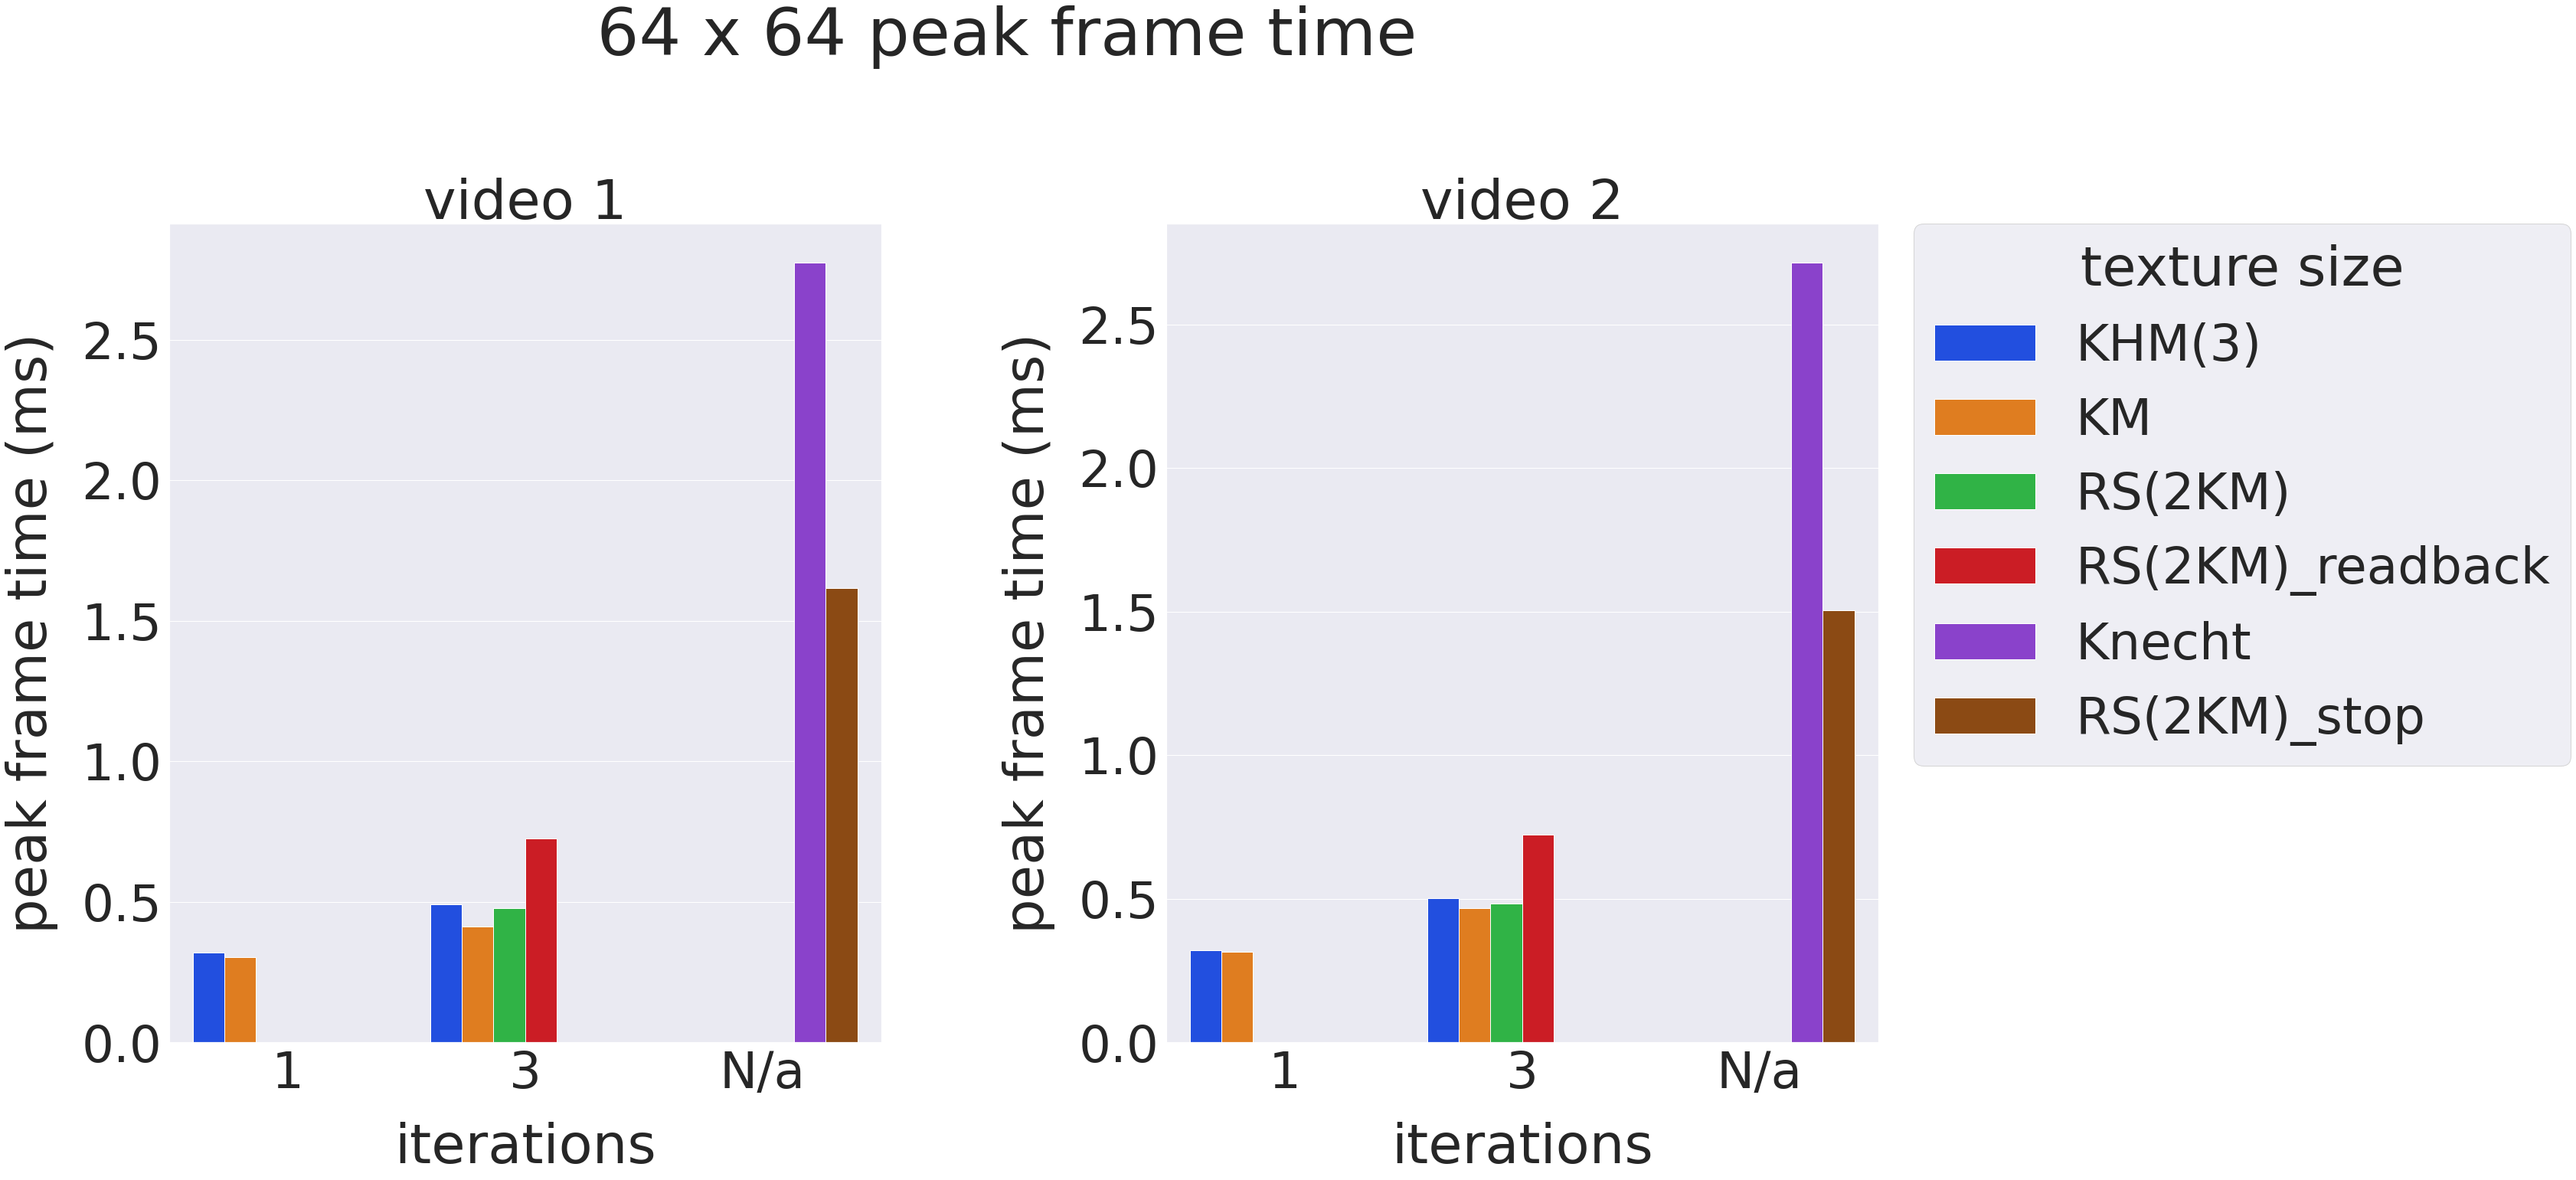

In [19]:

def analyze_frame_time_log(file_name):
    with open(file_name) as file:
        
        lines = file.readlines()
        log_entries = zip(
            lines[::4],
            lines[1::4],
            lines[2::4],
        )
        
        def parse_avg_frame_time(frame_time_string):
            parts = frame_time_string.strip().split(" ")
            match parts:
                case ["Average", "frame",  "time:", time_string, "ms"]:
                    return float(time_string)
                case _:
                    raise Exception(f"wrong format: {parts}")
        def parse_peak_frame_time(frame_time_string):
            parts = frame_time_string.strip().split(" ")
            match parts:
                case ["Peak", "frame",  "time:", time_string, "ms"]:
                    return float(time_string)
                case _:
                    raise Exception(f"wrong format: {parts}")
        log_entries = [
            (
                setting_line[:-5], # cut trailing .csv\n
                parse_avg_frame_time(avg_frame_time_str[:-1]), # cut trailing \n
                parse_peak_frame_time(peak_frame_time_str[:-1]) # cut trailing \n
            )
            for (setting_line, avg_frame_time_str, peak_frame_time_str) in log_entries
        ]
        
        unique_setting_strings = set(
            list(
                zip(*log_entries)
            )[0]
        )
        
        complete_runs = len(log_entries) // len(unique_setting_strings)
        
        log_entries = log_entries[:complete_runs * len(unique_setting_strings)]
        
        print(f"   complete runs: {complete_runs}")
        print(f"settings per run: {len(unique_setting_strings)}")
        print()
        
        aggregated_log_entries = []
        
        for unique_setting_string in unique_setting_strings:
            measured_avg_frame_times = [
                avg_frame_time
                for (setting_string, avg_frame_time, peak_frame_time) in log_entries
                    if setting_string == unique_setting_string
            ]
            measured_peak_frame_times = [
                peak_frame_time
                for (setting_string, avg_frame_time, peak_frame_time) in log_entries
                    if setting_string == unique_setting_string
            ]
            aggregated_log_entries.append(
                (
                    unique_setting_string,
                    min(measured_avg_frame_times),
                    min(measured_peak_frame_times)
                )
            )
            
        def parse_setting_string(settings_string):
            return {
                    name : value
                for name, value in [
                    setting_string.split(":")
                    for setting_string in settings_string.split("|")
                ]
            }
        
        aggregated_log_entries = [
            (
                parse_setting_string(settings_string),
                min_frame_time,
                peak_frame_time
            )
            for settings_string, min_frame_time, peak_frame_time in aggregated_log_entries
        ]
        
        aggregated_log_entries = [
            {
                "settings" : settings,
                "mean frame time" : min_frame_time,
                "peak frame time" : peak_frame_time
            }
            for settings, min_frame_time, peak_frame_time in aggregated_log_entries
        ]
        
        setting_names = aggregated_log_entries[0]["settings"].keys()
    
        def transform_settings(measurement):
            if (
                measurement["settings"]["algorithm"] == "Knecht"
                or measurement["settings"]["algorithm"] == "RS(2KM)_stop"
            ):
                measurement["settings"]["number of iterations"] = "N/a"
        
        def remove_irrelevant_settings():
            relevant_settings = []
            for setting_name in setting_names:
                first_value = aggregated_log_entries[0]["settings"][setting_name]
                for entry in aggregated_log_entries:
                    if entry["settings"][setting_name] != first_value:
                        relevant_settings.append(setting_name)
                        break
            for entry in aggregated_log_entries:
                entry["settings"] = {
                    setting_name : entry["settings"][setting_name]
                    for setting_name in entry["settings"]
                        if setting_name in relevant_settings
                }
                transform_settings(entry)
                
        remove_irrelevant_settings()
        
        aggregated_log_entries = sorted(
            aggregated_log_entries,
            key = lambda entry : (
                entry["settings"]["video file"],
                entry["settings"]["texture size"],
                entry["settings"]["number of iterations"],
                entry["settings"]["algorithm"]
            )
        )
        
        def print_aggregated_frame_times():
            print(f"{'video file':10} | {'texture size':12} | {'number of iterations':20} | {'algorithm':20} | {'frame time':10} | {'peak frame time':15}")
            print("-"*90)
            for entry in aggregated_log_entries:
                frame_time_string = f'{entry["mean frame time"]:0.3}'
                peak_frame_time_string = f'{entry["peak frame time"]:0.3}'
                print(
                    f"{entry['settings']['video file']:10} | "
                    f"{entry['settings']['texture size']:12} | "
                    f"{entry['settings']['number of iterations']:20} | {entry['settings']['algorithm']:20} | "
                    f"{frame_time_string:10} | "
                    f"{peak_frame_time_string:15}"
                )
        video_files = sorted(
            list(
                set(
                    [
                        entry["settings"]["video file"]
                        for entry in aggregated_log_entries
                    ]
                )
            )
        )
        print_aggregated_frame_times()
        
        def plot_stat(stat):
            assert(len(video_files) == 2)
            with sb.axes_style("darkgrid"):
                for texture_size in [512, 64]:
                    fig, axes = plt.subplots(1, 2, figsize=(40,22))
                    #backend = "".join(
                    #    file_name.split('/')[-1].split('.')[:-1]
                    #)
                    backend = ""
                    fig.suptitle(f"{backend} {texture_size} x {texture_size} {stat}")
                    fig.subplots_adjust(top=.8)
                    for video_file, index in zip(video_files, [0,1]):
                        data = pd.DataFrame(
                            [
                                (
                                    entry["settings"]["number of iterations"],
                                    entry["settings"]["algorithm"],
                                    entry["mean frame time"],
                                    entry["peak frame time"]
                                )
                                for entry in aggregated_log_entries
                                    if entry["settings"]["video file"] == video_file
                                        and entry["settings"]["texture size"] == str(texture_size)
                            ],
                            columns=[
                                "number of iterations",
                                "algorithm",
                                "mean frame time",
                                "peak frame time"
                            ]
                        )

                        g = sb.barplot(
                            data=data,
                            x="number of iterations",
                            y=stat,
                            hue="algorithm",
                            ci=None,
                            ax=axes[index],
                            palette="bright",

                        )
                        axes[index].set_ylabel(f"{stat} (ms)", labelpad=LABELPAD)
                        g.set_title(f"video {video_file}")

                        g.legend(
                            bbox_to_anchor=(1.05, 1),
                            loc="upper left",
                            borderaxespad=0,
                            title="texture size"
                        )

                        if index != 1:
                            g.legend().remove()

                    plt.subplots_adjust(
                        wspace=0.4,
                    )

                    for ax in axes:
                        ax.set_xlabel("iterations", labelpad=LABELPAD)

                    plt.show
        for stat in ["mean frame time", "peak frame time"]:
            plot_stat(stat)
        
display(Markdown("# Frame time analysis"))

display(Markdown("## IL2CPP build"))
analyze_frame_time_log("Frame time logs/IL2CPP.txt")